In [1]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
!pip install tensorflow-hub

import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
!pip install scikit-plot

from scikitplot.metrics import plot_roc

In [2]:
# Hyperparameters setting
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 42
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

## 1 | Visualization and Preprocessing of Dataset

In [3]:
# Define paths
DATASET_PATH = 'chest_xray/chest_xray/'
TRAIN_PATH = 'chest_xray/chest_xray/train/'
VAL_PATH = 'chest_xray/chest_xray/val/'
TEST_PATH = 'chest_xray/chest_xray/test/'


In [4]:
# Summary of the dataset
print('DATASET SUMMARY')
print('========================\n')
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

DATASET SUMMARY

There are 3 directories and 0 images in chest_xray/chest_xray/
There are 2 directories and 0 images in chest_xray/chest_xray/test
There are 0 directories and 234 images in chest_xray/chest_xray/test\NORMAL
There are 0 directories and 390 images in chest_xray/chest_xray/test\PNEUMONIA
There are 2 directories and 0 images in chest_xray/chest_xray/train
There are 0 directories and 1341 images in chest_xray/chest_xray/train\NORMAL
There are 0 directories and 3875 images in chest_xray/chest_xray/train\PNEUMONIA
There are 2 directories and 0 images in chest_xray/chest_xray/val
There are 0 directories and 8 images in chest_xray/chest_xray/val\NORMAL
There are 0 directories and 8 images in chest_xray/chest_xray/val\PNEUMONIA



In [5]:
%%time
train_images = glob.glob(f"{TRAIN_PATH}**/*.jpeg")
val_images = glob.glob(f"{VAL_PATH}**/*.jpeg")
test_images = glob.glob(f"{TEST_PATH}**/*.jpeg")

CPU times: total: 15.6 ms
Wall time: 31.5 ms


In [6]:
train_dataset = len(train_images)
val_dataset = len(val_images)
test_dataset = len(test_images)
total = train_dataset + val_dataset + test_dataset

# View the counts of train, val, test and total
print(f'train samples count:\t\t{train_dataset}')
print(f'dev/validation samples count:\t{val_dataset}')
print(f'test samples count:\t\t{test_dataset}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		5216
dev/validation samples count:	16
test samples count:		624
TOTAL:				5856


## Generate a Pandas DataFrame for the paths and labels


In [7]:
# Function to generate labels for given image paths
def generate_labels(image_paths):
    labels = []
    # Loop through each image path
    for _ in image_paths:
        # Check if the path contains the word "PNEUMONIA" and assign the appropriate label
        if ('PNEUMONIA' in _.replace('chest-xray-pneumonia', '')):
            labels.append('PNEUMONIA')
        else:
            labels.append('NORMAL')
            
    return labels

# Function to build a DataFrame using image paths and labels
def build_df(image_paths, labels):
    # Create a DataFrame with image paths and labels
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    # Encode the label: 0 for 'NORMAL' and 1 for 'PNEUMONIA'
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'NORMAL' else 1, axis=1)
    
    # Shuffle the DataFrame and reset the index
    return df.sample(frac=1, random_state=CFG.SEED).reset_index()


In [8]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
val_df = build_df(val_images, generate_labels(val_images))
test_df = build_df(test_images, generate_labels(test_images))

In [9]:
# Print val_df
train_df.head()

,index,image_path,label,label_encoded
0,1897,chest_xray/chest_xray/train\PNEUMONIA\person12...,PNEUMONIA,1
1,877,chest_xray/chest_xray/train\NORMAL\NORMAL2-IM-...,NORMAL,0
2,4503,chest_xray/chest_xray/train\PNEUMONIA\person61...,PNEUMONIA,1
3,4725,chest_xray/chest_xray/train\PNEUMONIA\person72...,PNEUMONIA,1
4,1595,chest_xray/chest_xray/train\PNEUMONIA\person11...,PNEUMONIA,1


In [10]:
# Print val_df
val_df.head()

,index,image_path,label,label_encoded
0,0,chest_xray/chest_xray/val\NORMAL\NORMAL2-IM-14...,NORMAL,0
1,1,chest_xray/chest_xray/val\NORMAL\NORMAL2-IM-14...,NORMAL,0
2,5,chest_xray/chest_xray/val\NORMAL\NORMAL2-IM-14...,NORMAL,0
3,14,chest_xray/chest_xray/val\PNEUMONIA\person1952...,PNEUMONIA,1
4,13,chest_xray/chest_xray/val\PNEUMONIA\person1951...,PNEUMONIA,1


In [11]:
# Print test_df
test_df.head()

,index,image_path,label,label_encoded
0,446,chest_xray/chest_xray/test\PNEUMONIA\person165...,PNEUMONIA,1
1,496,chest_xray/chest_xray/test\PNEUMONIA\person21_...,PNEUMONIA,1
2,215,chest_xray/chest_xray/test\NORMAL\NORMAL2-IM-0...,NORMAL,0
3,212,chest_xray/chest_xray/test\NORMAL\NORMAL2-IM-0...,NORMAL,0
4,479,chest_xray/chest_xray/test\PNEUMONIA\person173...,PNEUMONIA,1


In [12]:
# Load and preprocess an image
def _load(image_path):
    # Read the image
    image = tf.io.read_file(image_path)
    # Decode to tensor
    image = tf.io.decode_jpeg(image, channels=3)
    
    # Resize to the desired dimensions
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    
    # Normalize the image values to [0,1]
    image = tf.cast(image, tf.float32)/255.
    
    return image

# Display an image sample with its label
def display_sample(image, label, color_map='gray', fig_size=(8, 10)):
    # Plotting
    plt.figure(figsize=fig_size)
    plt.imshow(image, cmap=color_map)
    plt.title(f'Label: {label}', fontsize=16)
    return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


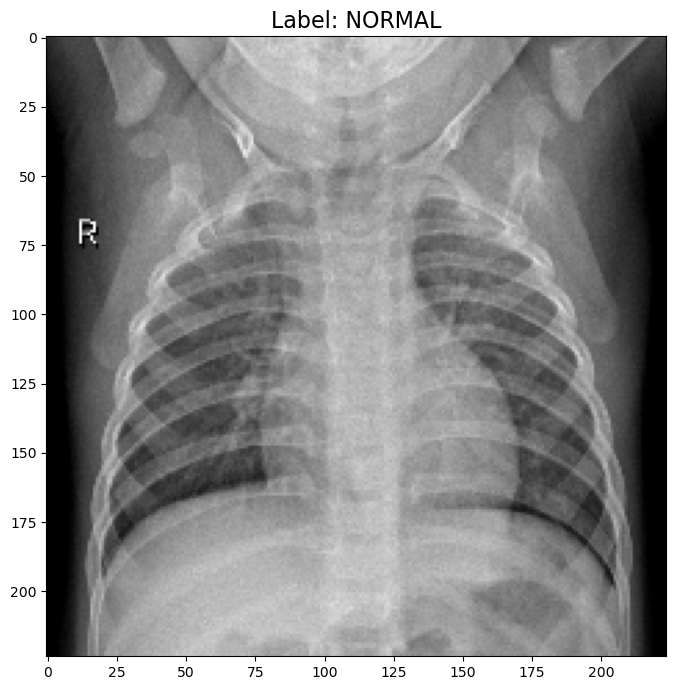

In [13]:
# Choose a random index from train_df
idx = random.sample(train_df.index.to_list(), 1)[0]

# Retrieve the image and label using the random index
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# Display the randomly selected image and its label
display_sample(sample_image, sample_label)

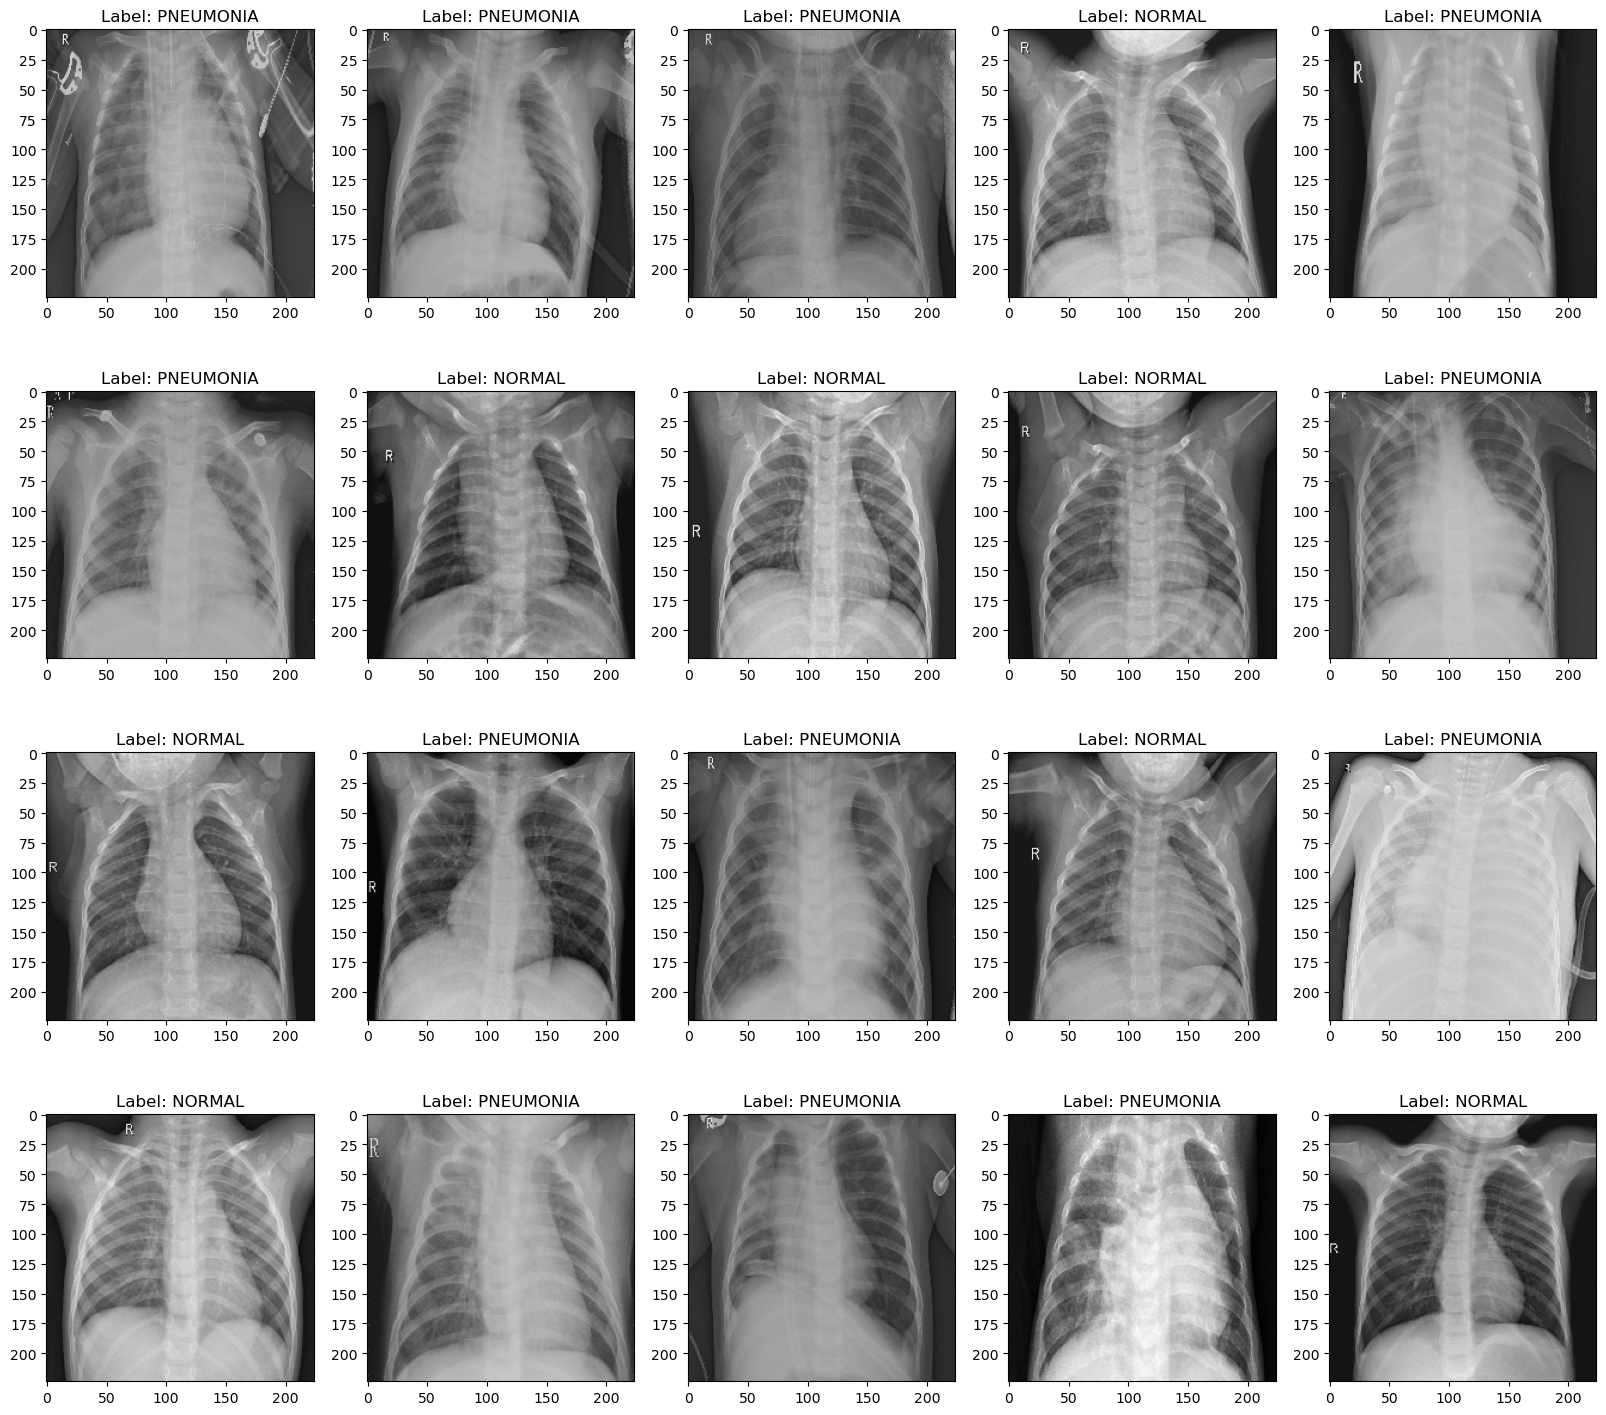

In [14]:
def display_mulitiple_samples(df, sample_loader, count=10, color_map='gray', fig_size=(14, 10)):
    """
    Display multiple image samples from a dataframe.
    
    Parameters:
    - df: The dataframe containing image paths and labels.
    - sample_loader: Function to load and preprocess the image.
    - count: Number of images to display.
    - color_map: Colormap to use for displaying the images.
    - fig_size: Figure size for the plot.
    """
    # Calculate number of rows needed based on count
    rows = count//5
    if count%5 > 0:
        rows +=1
        
    # Choose random indices from the dataframe for displaying
    idx = random.sample(df.index.to_list(), count)    
    fig = plt.figure(figsize=fig_size)
    
    # Loop through the random indices and display each image with its label
    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')
        plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map);
    
    return

# Test function by displaying 20 images from train_df with the 'jet' colormap
display_mulitiple_samples(train_df, _load, 
                       count=20, color_map='gray', 
                       fig_size=(20, 18))

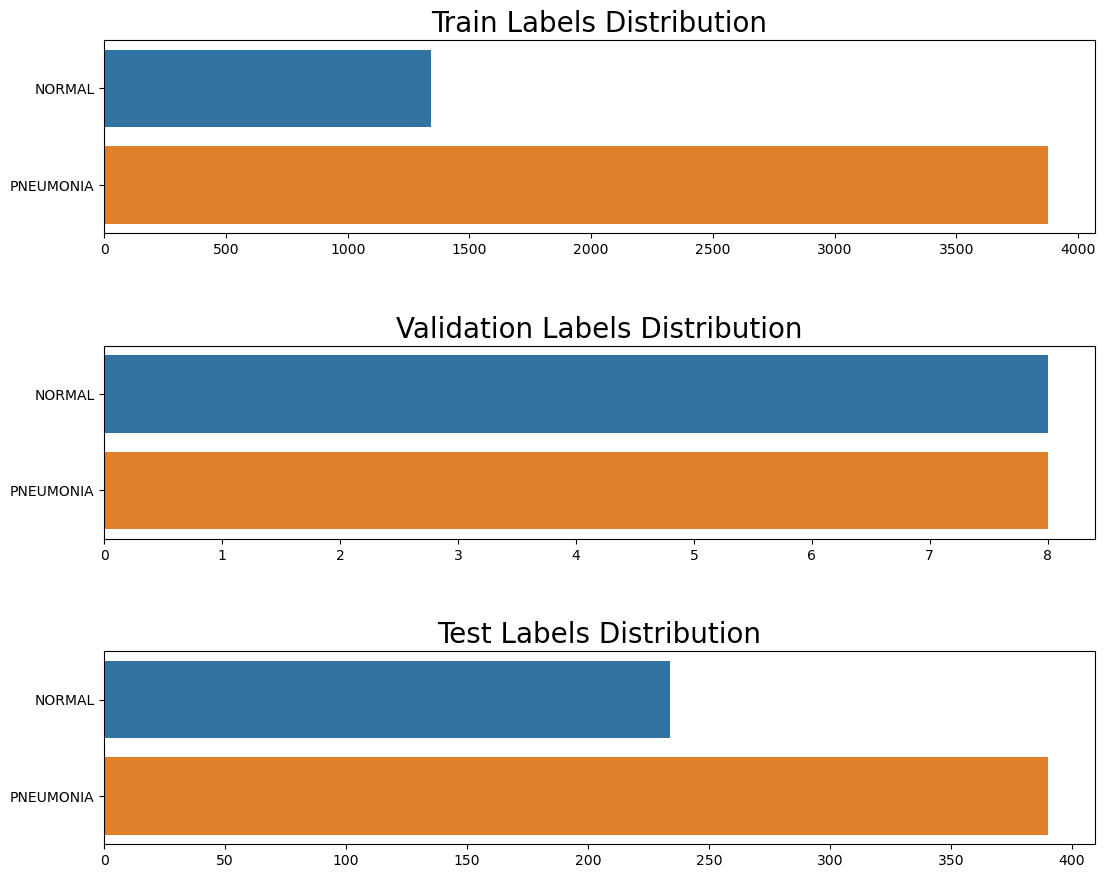

In [15]:
# Create a figure and a 3x1 grid of subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 10))

# Adjust the space between the plots
fig.tight_layout(pad=6.0)

# Display the distribution of labels in the training dataset
ax1.set_title('Train Labels Distribution', fontsize=20) # Set title for the first subplot
train_distribution = train_df['label'].value_counts().sort_values() # Get the distribution of labels in train_df

# Plot the distribution using seaborn's barplot
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Display the distribution of labels in the validation dataset
ax2.set_title('Validation Labels Distribution', fontsize=20) # Set title for the second subplot
val_distribution = val_df['label'].value_counts().sort_values() # Get the distribution of labels in val_df

# Plot the distribution using seaborn's barplot
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2)

# Display the distribution of labels in the test dataset
ax3.set_title('Test Labels Distribution', fontsize=20) # Set title for the third subplot
test_distribution = test_df['label'].value_counts().sort_values() # Get the distribution of labels in test_df

# Plot the distribution using seaborn's barplot
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax3);

## Generate New Train and Validation Dataset
We need to create a larger validation set as the existing one isn't sufficient for adjusting hyperparameters. By merging samples from the training set with the present validation set, we can achieve this. To ensure consistency and avoid potential discrepancies, we'll partition the data manually, bypassing the use of sklearn's train_test_split.

In [16]:
# Seperate samples based on their labels: 'PNEUMONIA' or 'NORMAL'
train_pneumonia = train_df[train_df['label'] == 'PNEUMONIA']
train_normal = train_df[train_df['label'] == 'NORMAL']

# Set the proportion of the dataset to be used for validation
validation_size = 0.2

# Extract a portion of 'PNEUMONIA' and 'NORMAL' labeled data for new validation set
val_pneumonia = train_pneumonia[:int(len(train_pneumonia) * validation_size)]
val_normal = train_normal[:int(len(train_normal) * validation_size)]

# Extract the remaining data for the new training set
train_new_pneumonia = train_pneumonia[int(len(train_pneumonia) * validation_size):]
train_new_normal = train_normal[int(len(train_normal) * validation_size):]

# Combine the extracted validation samples with the existing validation set, then shuffle the records
val_split_df = pd.concat([val_df, val_pneumonia, val_normal], axis=0) \
                 .sample(frac=1, random_state=CFG.SEED) \
                 .reset_index(drop=True)

# Merge the new training samples and shuffle them
train_split_df = pd.concat([train_new_pneumonia, train_new_normal], axis=0) \
                   .sample(frac=1, random_state=CFG.SEED) \
                   .reset_index(drop=True)

In [17]:
# Display fisrt 10 samples from the new validation set
val_split_df.head(10)

,index,image_path,label,label_encoded
0,4447,chest_xray/chest_xray/train\PNEUMONIA\person5_...,PNEUMONIA,1
1,2726,chest_xray/chest_xray/train\PNEUMONIA\person16...,PNEUMONIA,1
2,2228,chest_xray/chest_xray/train\PNEUMONIA\person14...,PNEUMONIA,1
3,2451,chest_xray/chest_xray/train\PNEUMONIA\person15...,PNEUMONIA,1
4,833,chest_xray/chest_xray/train\NORMAL\NORMAL2-IM-...,NORMAL,0
5,1129,chest_xray/chest_xray/train\NORMAL\NORMAL2-IM-...,NORMAL,0
6,4816,chest_xray/chest_xray/train\PNEUMONIA\person76...,PNEUMONIA,1
7,3966,chest_xray/chest_xray/train\PNEUMONIA\person47...,PNEUMONIA,1
8,5211,chest_xray/chest_xray/train\PNEUMONIA\person99...,PNEUMONIA,1
9,3151,chest_xray/chest_xray/train\PNEUMONIA\person27...,PNEUMONIA,1


In [18]:
# Display fisrt 10 samples from the new training set
train_split_df.head(10)

,index,image_path,label,label_encoded
0,2318,chest_xray/chest_xray/train\PNEUMONIA\person14...,PNEUMONIA,1
1,1469,chest_xray/chest_xray/train\PNEUMONIA\person10...,PNEUMONIA,1
2,1725,chest_xray/chest_xray/train\PNEUMONIA\person12...,PNEUMONIA,1
3,3153,chest_xray/chest_xray/train\PNEUMONIA\person27...,PNEUMONIA,1
4,1570,chest_xray/chest_xray/train\PNEUMONIA\person11...,PNEUMONIA,1
5,460,chest_xray/chest_xray/train\NORMAL\IM-0626-000...,NORMAL,0
6,3599,chest_xray/chest_xray/train\PNEUMONIA\person38...,PNEUMONIA,1
7,3919,chest_xray/chest_xray/train\PNEUMONIA\person46...,PNEUMONIA,1
8,4343,chest_xray/chest_xray/train\PNEUMONIA\person57...,PNEUMONIA,1
9,1735,chest_xray/chest_xray/train\PNEUMONIA\person12...,PNEUMONIA,1


## View New Train & Validation Labels Distribution


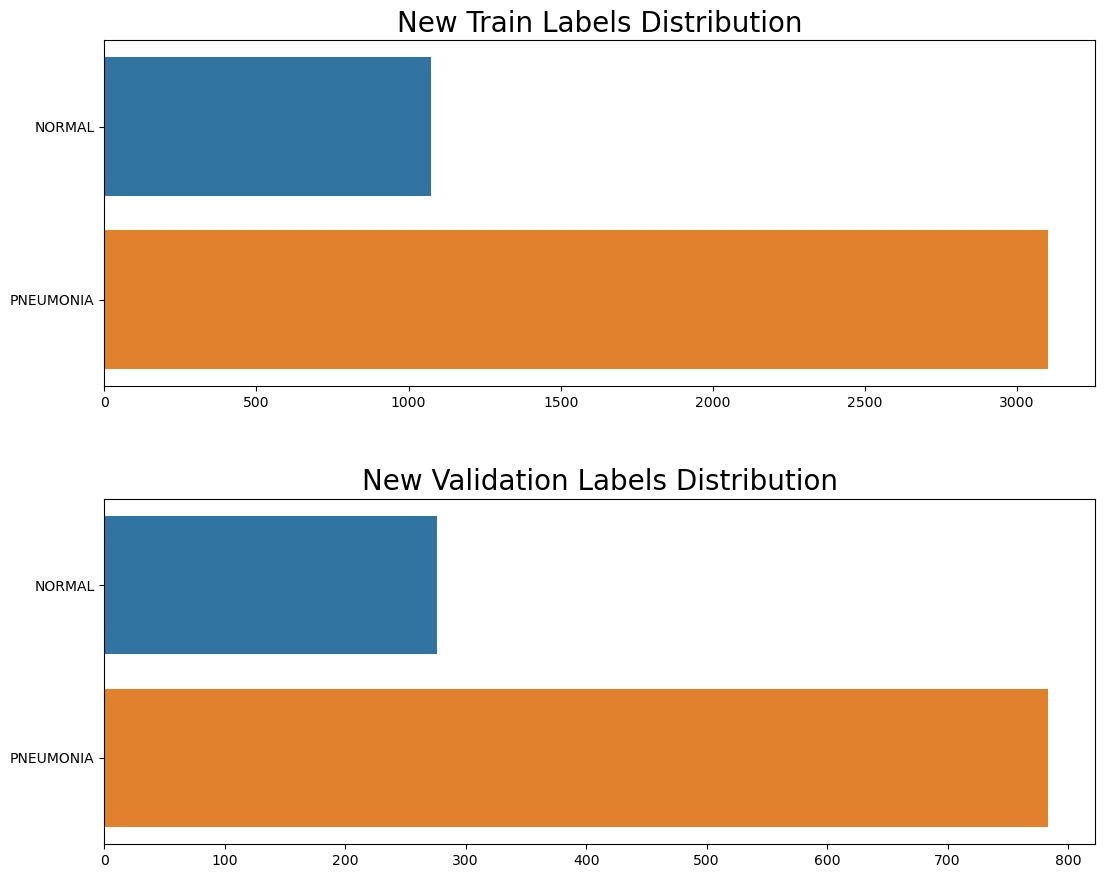

In [19]:
# Initialize a figure with two subplots and specify its size
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10))

# Adjust the spacing between the subplots for better visualization
fig.tight_layout(pad=6.0)

# Plot the distribution of labels in the new training set
ax1.set_title('New Train Labels Distribution', fontsize=20)
train_split_distribution = train_split_df['label'].value_counts().sort_values()
sns.barplot(x=train_split_distribution.values,
            y=list(train_split_distribution.keys()),
            orient="h",
            ax=ax1);

# Plot the distribution of labels in the new validation set
# Plot Validation Class Distribution
ax2.set_title('New Validation Labels Distribution', fontsize=20)
val_split_distribution = val_split_df['label'].value_counts().sort_values()
sns.barplot(x=val_split_distribution.values,
            y=list(val_split_distribution.keys()),
            orient="h",
            ax=ax2);


## 2 | Build Input Data Pipeline with tf.data API

To train models using this dataset, we will establish an input data pipeline with TensorFlow's tf.data API for efficient loading and feeding of image data to the model.

For expedited training, we will batch the data and ensure that subsequent data is prefetched while the model processes a previously fed sample.

In [20]:
# Define an augmentation layer to enhance dataset diversity
# - Randomly flip images both horizontally and vertically
# - Randomly zoom into images with specified height and width factors
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.2), width_factor=(-0.1, 0.2)),
], name='augmentation_layer')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


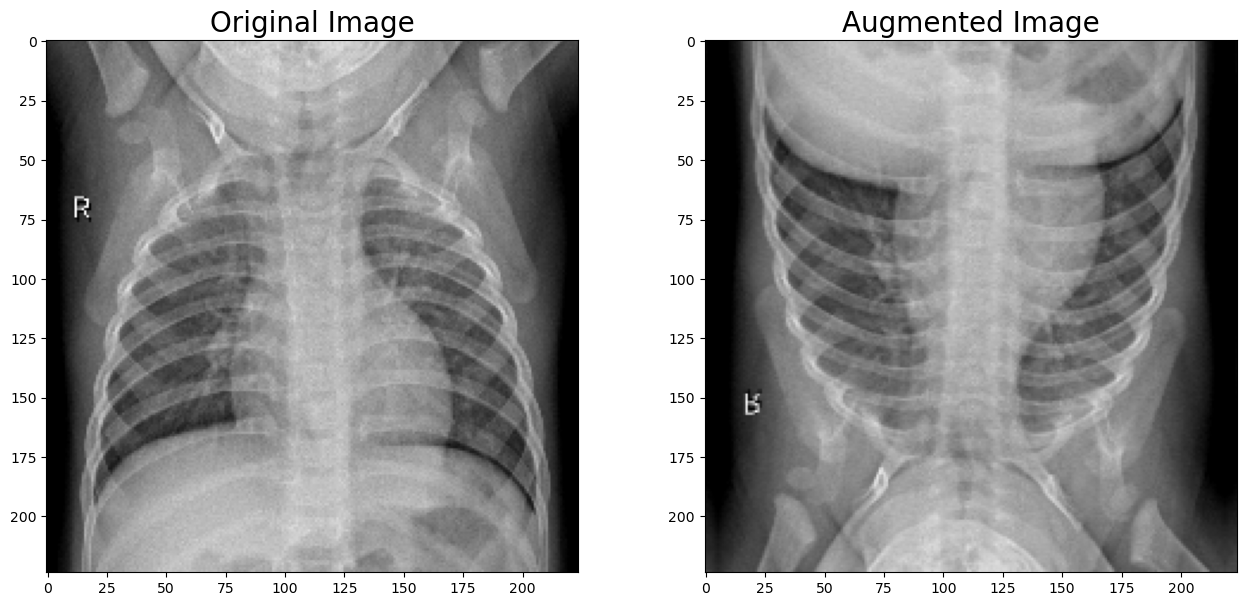

In [21]:
# Initialize a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Adjust the spacing between the two subplots for better visualization
fig.tight_layout(pad=6.0)

# Display the original image in the first subplot
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(sample_image);

# Apply and display the augmented version of the image in the second subplot
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(augmentation_layer(sample_image));

## Build input pipelines

In [22]:
# Code reference from: "How to Create Efficient Training Pipelines with TensorFlow data.Dataset" by Greg Hogg
# Available: https://www.youtube.com/watch?v=4WNz2xrGe8w&ab_channel=GregHogg

def encode_labels(labels):
    # Convert labels to one-hot encoded format with 2 classes
    return tf.one_hot(labels, depth=2).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    
    # Extract image paths and their respective labels from the DataFrame
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    
    # Configure autotuning for optimization
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Initialize a TensorFlow dataset with image paths and labels
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    # If augmentation is enabled, apply both the augmentation layer and the load function to the dataset
    # If not, just apply the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)
    
    # Shuffle the dataset if required, useful to prevent patterns during training
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Organize data into batches for training
    ds = ds.batch(batch_size)
    
    # If caching is specified, cache the dataset (either in memory or on disk)
    # Note: Caching in memory is advisable if the dataset is small enough
    if cache != None:
        ds = ds.cache(cache)
    
     # If prefetch is enabled, prefetch next batch while training current batch
    # Helps in speeding up the training process
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the final configured dataset
    return ds

In [23]:
# Create a training data input pipeline with data augmentation
# No shuffling or prefetching is applied here
train_ds = create_pipeline(train_split_df, _load, augment=True, 
                           batch_size=32, shuffle=False, prefetch=False)

# Create a validation data input pipeline
# No data augmentation, shuffling, or prefetching is applied
val_ds = create_pipeline(val_split_df, _load, 
                         batch_size=32, shuffle=False, prefetch=False)

# Create a test data input pipeline
# No data augmentation, shuffling, or prefetching is applied
test_ds = create_pipeline(test_df, _load, 
                          batch_size=32, shuffle=False, prefetch=False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [24]:
# View string representation of datasets
print('----------------------------------------')
print('Train Input Data Pipeline:\n\n', train_ds)
print('----------------------------------------')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('----------------------------------------')
print('Test Input Data Pipeline:\n\n', test_ds)
print('----------------------------------------')

----------------------------------------
Train Input Data Pipeline:

 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
----------------------------------------
Validation Input Data Pipeline:

 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
----------------------------------------
Test Input Data Pipeline:

 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
----------------------------------------


## 3 | Baseline Model: Convolutional Neural Network (CNN)

## Convolutional Neural Networks


In [25]:
def cnn_model():
    # Use GlorotNormal initializer for layer weights
    initializer = tf.keras.initializers.GlorotNormal()
    
    # Define the input layer
    input_layer = Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image')
    
    # First set of convolutional layers followed by max pooling
    x = Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer)(input_layer)
    x = Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer)(x)
    x = MaxPooling2D(pool_size=2, padding='valid')(x)
    
    # Second set of convolutional layers followed by max pooling
    x = Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer)(x)
    x = Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer)(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    # Flatten the output from the convolutions
    x = Flatten()(x)
    
    # Apply dropout to reduce overfitting
    x = Dropout(0.2)(x)
    
    # Output dense layer with 2 nodes for binary classification using sigmoid activation
    output_layer = Dense(2, activation='sigmoid', kernel_initializer=initializer)(x)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer, name='cnn_sequential_model')
    
    # Return the constructed model
    return model


In [26]:
# Instantiate the CNN model
model_cnn = cnn_model()

# Display the architecture and parameters of the instantiated model
model_cnn.summary()

Model: "cnn_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 8)       584       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 8)       584       
                                              

C:\Users\alexi\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Train Model
To train this model we'll use Binary Crossentropy as the loss function since this is a classification problem for binary labels. As for the optimizer, we'll use the Adam optimizer with 0.001 as the (default) learning rate.

To prevent the occurance of overfitting during training we'll have to make use of TensorFlow's Callback API to implement the EarlyStopping & ReduceLROnPlateau callbacks. The only metrics we'll track during the training of the model will be the loss and accuracy metrics.

In [27]:
# Function to train the provided model
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    
    # Initialize an empty dictionary to store the training history
    model_history = {}
    
    # If validation data is provided, train the model with validation data 
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    
    # If validation data is not provided, train the model without it 
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    # Return the training history
    return model_history

In [28]:
# Define Early Stopping Callback
# This stops training the model when 'val_loss' stops improving
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True)

# Define Reduce Learning Rate on Plateau Callback
# This reduces the learning rate when a metric ('val_loss') has stopped improving
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

# Training configuration parameters
EPOCHS = CFG.EPOCHS            # Number of epochs for training
CALLBACKS = [early_stopping_callback, reduce_lr_callback]   # List of callbacks to be used during training
METRICS = ['accuracy']   # Metrics to be evaluated during training

In [29]:
# Set the random seed for reproducibility in TensorFlow operations
tf.random.set_seed(CFG.SEED)

# Compile the CNN model
# This specifies the loss function, optimizer, and metrics to track during training
model_cnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),               # Loss function for binary classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam optimization algorithm
    metrics=METRICS                                         # Metrics to be evaluated during training
)

# Begin model training
print(f'Training {model_cnn.name}.')                               # Display the model's name
print(f'Train on {len(train_split_df)} samples, validate on {len(val_split_df)} samples.')  # Display training/validation data size
print('----------------------------------')

cnn_history = train_model(           # Train the model and save its history
    model_cnn,                       # CNN model
    EPOCHS,                          # Number of training epochs
    CALLBACKS,                       # Callbacks to be used during training
    train_ds,                        # Training dataset
    val_ds,                          # Validation dataset
    shuffling=False                  # Whether to shuffle the dataset before each epoch
)


Training cnn_sequential_model.
Train on 4173 samples, validate on 1059 samples.
----------------------------------
Epoch 1/10
131/131 [==============================] - 94s 713ms/step - loss: 0.3295 - accuracy: 0.8572 - val_loss: 0.1890 - val_accuracy: 0.9207 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 102s 777ms/step - loss: 0.1739 - accuracy: 0.9351 - val_loss: 0.1433 - val_accuracy: 0.9396 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - 106s 804ms/step - loss: 0.1630 - accuracy: 0.9377 - val_loss: 0.2014 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9444
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
131/131 [==============================] - 108s 821ms/step - loss: 0.1512 - accuracy: 0.9444 - val_loss: 0.2102 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 5/10
131/131 [==============================] - 107s 815ms/step - loss: 0.1251 - a

In [30]:
# Evaluate the performance of the CNN model on the test dataset
# This provides metrics such as loss and accuracy for the test set
cnn_evaluation = model_cnn.evaluate(test_ds)

20/20 [==============================] - 5s 231ms/step - loss: 0.5327 - accuracy: 0.8237


In [31]:
# Generate prediction probabilities for each class using the CNN model on the test dataset
cnn_test_probabilities = model_cnn.predict(test_ds, verbose=1)

# Determine the class predictions by selecting the class with the highest probability for each sample
cnn_test_predictions = tf.argmax(cnn_test_probabilities, axis=1)

20/20 [==============================] - 5s 230ms/step


## 4 | Transfer Learning: ResNet50
ResNet50 refines the original ResNet by introducing bottleneck layers to minimize parameter count and boost performance. It also adopts pre-activation, placing batch normalization and ReLU before convolutions, enhancing the model's learning capacity by providing direct access to prior activations.

## Build ResNet Model

In [32]:
# Define a model using the ResNet50 V2 architecture
def resnet_model():
    # Define the input layer
    input_layer = Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image')
    
    # Load the pre-trained ResNet50V2 model (excluding the top classification layers)
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)
    
    # Freeze the layers of the pre-trained ResNet50V2 model
    for layer in resnet_base.layers:
        layer.trainable = False
    
    # Extract features from the ResNet50V2 model
    x = resnet_base.output
    
    # Apply Global Average Pooling to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)
    
    # Add a fully connected layer with 256 units and ReLU activation for feature extraction
    x = Dense(256, activation='relu')(x)
    
    # Apply Batch Normalization for improved training stability
    x = BatchNormalization()(x)
    
    # Apply Dropout with a 20% dropout rate for regularization
    x = Dropout(0.2)(x) 
    
    # Output dense layer with 2 neurons (assuming binary classification) 
    # and sigmoid activation for the final classification
    output_layer = Dense(2, activation='sigmoid', dtype=tf.float32)(x)
    
    # Create the model by specifying the input and output layers
    model = Model(inputs=input_layer, outputs=output_layer, name='resnet_model')
    
    # Return the constructed model
    return model



In [33]:
# Instantiate the ResNet model
model_resnet = resnet_model()

# Display the architecture and details of the ResNet model
model_resnet.summary()

Model: "resnet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_image[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                       

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [34]:
# Set the random seed for TensorFlow to ensure reproducibility
tf.random.set_seed(CFG.SEED)

# Compile the ResNet model with the specified loss function, optimizer, and metrics
model_resnet.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=METRICS
)

# Display training initiation details for the ResNet model
print(f'Starting training for {model_resnet.name}.')
print(f'Training on {len(train_split_df)} samples with validation on {len(val_split_df)} samples.')
print('----------------------------------')

# Train the ResNet model:
# - model_resnet: The ResNet model we've defined previously.
# - EPOCHS: The number of epochs or iterations we want to train our model for.
# - CALLBACKS: A set of functions (callbacks) to be applied during training, such as early stopping or learning rate adjustments.
# - train_ds: The training dataset.
# - val_ds: The validation dataset used to evaluate the model's performance on unseen data after each epoch.
# - shuffling=False: Indicates that the data shouldn't be shuffled before each epoch.
resnet_history = train_model(
    model_resnet, EPOCHS, CALLBACKS,
    train_ds, val_ds,
    shuffling=False
)


Starting training for resnet_model.
Training on 4173 samples with validation on 1059 samples.
----------------------------------
Epoch 1/10
131/131 [==============================] - 340s 3s/step - loss: 0.5099 - accuracy: 0.7954 - val_loss: 0.7603 - val_accuracy: 0.2606 - lr: 1.0000e-04
Epoch 2/10
131/131 [==============================] - 334s 3s/step - loss: 0.3866 - accuracy: 0.8720 - val_loss: 0.6715 - val_accuracy: 0.4674 - lr: 1.0000e-04
Epoch 3/10
131/131 [==============================] - 329s 3s/step - loss: 0.3193 - accuracy: 0.9027 - val_loss: 0.8578 - val_accuracy: 0.2616 - lr: 1.0000e-04
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.9097
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
131/131 [==============================] - 332s 3s/step - loss: 0.2680 - accuracy: 0.9097 - val_loss: 1.1379 - val_accuracy: 0.2616 - lr: 1.0000e-04
Epoch 5/10
131/131 [==============================] - 328s 3s/step - l

In [35]:
# Assess the performance of the ResNet model using the test dataset
resnet_evaluation = model_resnet.evaluate(test_ds)

20/20 [==============================] - 38s 2s/step - loss: 0.4112 - accuracy: 0.7965


In [36]:
# Obtain the prediction probabilities from the ResNet model for the test dataset
resnet_test_probabilities = model_resnet.predict(test_ds, verbose=1)

# Convert the probabilities into class predictions
resnet_test_predictions = tf.argmax(resnet_test_probabilities, axis=1)

20/20 [==============================] - 38s 2s/step


In [37]:
# Fine tuning for resnet
# Set the last 20 layers of the EfficientNetV2 model as trainable.
# This means we'll fine-tune these layers, while keeping the rest frozen.
# It's a common strategy in transfer learning to only adjust the topmost layers.
for layer in model_resnet.layers[-20:]:  # Unfreeze the last 20 layers
#     if not isinstance(layer, BatchNormalization):
    layer.trainable = True

In [38]:
# Iterate through the layers of the ResNet base model and print their trainability status
for layer_number, layer in enumerate(model_resnet.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_image False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_

In [39]:
from tensorflow.keras.optimizers import Adam

model_resnet.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
# Display a summary of the model architecture
model_resnet.summary()

Model: "resnet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_image[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                       

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [40]:
# Fine-tuning the ResNet model
history_resnet_fine = train_model(
    model_resnet,      # The predefined ResNet model for our task
    EPOCHS,            # Number of training iterations
    CALLBACKS,         # Callback functions applied during training (e.g., early stopping)
    train_ds,          # Dataset for training
    val_ds,            # Dataset for validation
    shuffling=False    # Ensures data isn't shuffled before each epoch
)


Epoch 1/10
131/131 [==============================] - 381s 3s/step - loss: 0.2358 - accuracy: 0.9178 - val_loss: 0.8429 - val_accuracy: 0.5817 - lr: 1.0000e-04
Epoch 2/10
131/131 [==============================] - 378s 3s/step - loss: 0.1898 - accuracy: 0.9307 - val_loss: 26.2106 - val_accuracy: 0.2606 - lr: 1.0000e-04
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.9413
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
131/131 [==============================] - 376s 3s/step - loss: 0.1659 - accuracy: 0.9413 - val_loss: 8.0841 - val_accuracy: 0.7394 - lr: 1.0000e-04
Epoch 4/10
131/131 [==============================] - 376s 3s/step - loss: 0.1515 - accuracy: 0.9466 - val_loss: 0.4266 - val_accuracy: 0.8432 - lr: 1.0000e-05
Epoch 5/10
131/131 [==============================] - 377s 3s/step - loss: 0.1369 - accuracy: 0.9538 - val_loss: 1.2638 - val_accuracy: 0.4060 - lr: 1.0000e-05
Epoch 6/10
131/131 [==================

In [41]:
# Assess the performance of the ResNet model using the test dataset
resnet_evaluation_fine = model_resnet.evaluate(test_ds)

20/20 [==============================] - 40s 2s/step - loss: 0.3915 - accuracy: 0.8349


In [42]:
# Obtain the prediction probabilities from the ResNet model for the test dataset
resnet_test_probabilities_fine = model_resnet.predict(test_ds, verbose=1)

# Convert the probabilities into class predictions
resnet_test_predictions_fine = tf.argmax(resnet_test_probabilities_fine, axis=1)

20/20 [==============================] - 38s 2s/step


## 5 | Transfer Learning: EfficientNetB0
EfficientNet is a state-of-the-art convolutional neural network that uses a unique scaling method. Instead of arbitrarily scaling dimensions, it uniformly scales depth, width, and resolution with fixed coefficients, achieving top accuracy with significantly fewer computations and parameters.

## Define EfficientNetB0 Model


In [43]:
def efficientnet_b0_model():
    """
    Constructs a neural network model based on the EfficientNetB0 architecture for binary classification.
    The model utilizes transfer learning by initializing with weights pre-trained on ImageNet.
    The final layers are tailored for binary classification.
    """
    
    # Define the input tensor with the desired image size and data type
    input_layer = Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image')
    
    # Load the pre-trained EfficientNetB0 model excluding its top classification layers
    # This acts as a feature extractor for our specific task
    efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)
    
    # Set all layers of the base model as trainable for fine-tuning
    for layer in efficientnet_base.layers:
        layer.trainable = True

    # Attach custom layers for our binary classification task
    x = efficientnet_base.output
    x = GlobalAveragePooling2D()(x)        # Reduces spatial dimensions by computing the average for each feature map
    x = Dense(256, activation='relu')(x)   # Fully connected layer with 256 units and ReLU activation
    x = BatchNormalization()(x)            # Batch normalization for improving training stability
    x = Dropout(0.2)(x)                    # Dropout layer for regularization, reduces overfitting

    # Define the final output layer with 2 neurons (binary classification)
    # Using a sigmoid activation function for class probabilities
    output_layer = Dense(2, activation='sigmoid', dtype=tf.float32)(x)

    # Construct and compile the full model
    model = Model(inputs=input_layer, outputs=output_layer, name='efficientnet_b0_model')

    return model


In [44]:

# Create the model
model_efficientnet_b0 = efficientnet_b0_model()

# Display a comprehensive summary of the constructed EfficientNet V1 model
model_efficientnet_b0.summary()



Model: "efficientnet_b0_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_image[0][0]']            
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalizati

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

In [45]:
# Set random seed for reproducibility
tf.random.set_seed(CFG.SEED)

# Configure the EfficientNet V1 model with loss function, optimizer, and evaluation metric
model_efficientnet_b0.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=METRICS
)

# Start training the EfficientNet V1 model 
print(f'Training {model_efficientnet_b0.name}.')
print(f'Training on {len(train_split_df)} samples and validating on {len(val_split_df)} samples.')
print('----------------------------------')

# Execute the training process for the model
efficientnet_b0_history = train_model(
    model_efficientnet_b0, EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)



Training efficientnet_b0_model.
Training on 4173 samples and validating on 1059 samples.
----------------------------------
Epoch 1/10
131/131 [==============================] - 665s 5s/step - loss: 0.3362 - accuracy: 0.8869 - val_loss: 0.6874 - val_accuracy: 0.7044 - lr: 1.0000e-04
Epoch 2/10
131/131 [==============================] - 640s 5s/step - loss: 0.1395 - accuracy: 0.9626 - val_loss: 0.6416 - val_accuracy: 0.7394 - lr: 1.0000e-04
Epoch 3/10
131/131 [==============================] - 663s 5s/step - loss: 0.1008 - accuracy: 0.9698 - val_loss: 0.6877 - val_accuracy: 0.7394 - lr: 1.0000e-04
Epoch 4/10
131/131 [==============================] - 657s 5s/step - loss: 0.0764 - accuracy: 0.9753 - val_loss: 0.5096 - val_accuracy: 0.7394 - lr: 1.0000e-04
Epoch 5/10
131/131 [==============================] - 638s 5s/step - loss: 0.0598 - accuracy: 0.9837 - val_loss: 0.2951 - val_accuracy: 0.8924 - lr: 1.0000e-04
Epoch 6/10
131/131 [==============================] - 618s 5s/step - loss: 0

In [46]:
# Assess the performance of the EfficientNet V1 model on the test dataset
efficientnet_b0_evaluation = model_efficientnet_b0.evaluate(test_ds)

20/20 [==============================] - 21s 1s/step - loss: 0.3880 - accuracy: 0.8910


In [47]:
# Calculate probabilities for each class using the EfficientNet V1 model
# Then, determine the predicted class based on the highest probability
efficientnet_b0_test_probabilities = model_efficientnet_b0.predict(test_ds, verbose=1)
efficientnet_b0_test_predictions = tf.argmax(efficientnet_b0_test_probabilities, axis=1)

20/20 [==============================] - 21s 980ms/step


In [48]:
# Fine tuning for efficientnet_b0
# Set the last 20 layers of the EfficientNetV2 model as trainable.
# This means we'll fine-tune these layers, while keeping the rest frozen.
# It's a common strategy in transfer learning to only adjust the topmost layers.
for layer in model_efficientnet_b0.layers[:-20]:  # Unfreeze the last 20 layers
    layer.trainable = True

In [49]:
model_efficientnet_b0.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
# Display a summary of the model architecture
model_efficientnet_b0.summary()

Model: "efficientnet_b0_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_image[0][0]']            
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalizati

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

In [50]:
history_efficient_b0_fine = train_model(model_efficientnet_b0, 
                                  EPOCHS, CALLBACKS,
                                  train_ds, val_ds,
                                  shuffling=False)

Epoch 1/10
131/131 [==============================] - 686s 5s/step - loss: 0.0359 - accuracy: 0.9899 - val_loss: 0.6564 - val_accuracy: 0.7394 - lr: 1.0000e-04
Epoch 2/10
131/131 [==============================] - 625s 5s/step - loss: 0.0233 - accuracy: 0.9933 - val_loss: 1.1609 - val_accuracy: 0.7422 - lr: 1.0000e-04
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9923
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
131/131 [==============================] - 621s 5s/step - loss: 0.0239 - accuracy: 0.9923 - val_loss: 0.8880 - val_accuracy: 0.7394 - lr: 1.0000e-04
Epoch 4/10
131/131 [==============================] - 624s 5s/step - loss: 0.0222 - accuracy: 0.9942 - val_loss: 0.1544 - val_accuracy: 0.9443 - lr: 1.0000e-05
Epoch 5/10
131/131 [==============================] - 621s 5s/step - loss: 0.0137 - accuracy: 0.9962 - val_loss: 0.4561 - val_accuracy: 0.9056 - lr: 1.0000e-05
Epoch 6/10
131/131 [===================

In [58]:
# Assess the performance of the ResNet model using the test dataset
efficientnet_b0_evaluation_fine = model_efficientnet_b0.evaluate(test_ds)

20/20 [==============================] - 18s 847ms/step - loss: 0.5783 - accuracy: 0.8237


In [59]:
# Calculate probabilities for each class using the EfficientNet V1 model
# Then, determine the predicted class based on the highest probability
efficientnet_b0_test_probabilities_fine = model_efficientnet_b0.predict(test_ds, verbose=1)
efficientnet_b0_test_predictions_fine = tf.argmax(efficientnet_b0_test_probabilities, axis=1)

20/20 [==============================] - 17s 844ms/step


## 6 | Transfer Learning: EfficientNet V2 B0
EfficientNetV2 offers faster training and superior parameter efficiency compared to its predecessor, EfficientNetV1.

In [60]:
# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [61]:
# Load the EfficientNet V2 B0 model from TensorFlow Hub
# URL represents the pre-trained EfficientNet V2 B0 model
efficientnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2'
model_name = 'efficientnet_v2_b0'

# We set the model to be non-trainable for inference purposes only
set_trainable=False 

# Fetch the model using the custom function 'get_tfhub_model'
efficientnet_v2_b0 = get_tfhub_model(efficientnet_v2_url, model_name, model_trainable=set_trainable)


## Define EfficientNet V2 Model

In [62]:
# Define the EfficientNet V2 model architecture
def efficientnet_v2_model():
    
    # Initialize weights using the Glorot Normal initializer
    initializer = tf.keras.initializers.GlorotNormal()
    
    # Construct the model sequentially
    efficientnet_v2_sequential = Sequential([
        # Define the input layer with the expected image size and data type
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        
        # Incorporate the pre-trained EfficientNet V2 B0 model
        efficientnet_v2_b0,
        
        # Add a dropout layer to prevent overfitting
        layers.Dropout(0.2),
        
        # Define the output layer with two neurons (assuming a binary classification task)
        # Using the sigmoid activation function and the specified initializer
        layers.Dense(2, dtype=tf.float32, activation='sigmoid', kernel_initializer=initializer)
    ], name='efficientnet_v2_sequential_model')
    
    # Return the constructed model
    return efficientnet_v2_sequential


In [63]:
# Generate the EfficientNet V2 model
model_efficientnet_v2 = efficientnet_v2_model()

# Display a summary of the EfficientNet V2 model architecture
model_efficientnet_v2.summary()


Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_v2_b0 (KerasLa  (None, 1280)             5919312   
 yer)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 5,921,874
Trainable params: 2,562
Non-trainable params: 5,919,312
_________________________________________________________________


## Train EfficientNet V2 Model

In [64]:
# Set the random seed for reproducibility
tf.random.set_seed(CFG.SEED)

# Compile the EfficientNet V2 model with the specified loss function, optimizer, and evaluation metrics
model_efficientnet_v2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Begin training the EfficientNet V2 model
print(f'Training {model_efficientnet_v2.name}.')
print(f'Train on {len(train_split_df)} samples, validate on {len(val_split_df)} samples.')
print('----------------------------------')

# Execute the training process using the specified datasets, epoch count, and callbacks. Note that shuffling is disabled.
efficientnet_v2_history = train_model(
    model_efficientnet_v2, EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)


Training efficientnet_v2_sequential_model.
Train on 4173 samples, validate on 1059 samples.
----------------------------------
Epoch 1/10
131/131 [==============================] - 144s 1s/step - loss: 0.3950 - accuracy: 0.8454 - val_loss: 0.1823 - val_accuracy: 0.9320 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 139s 1s/step - loss: 0.2009 - accuracy: 0.9255 - val_loss: 0.1474 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - 143s 1s/step - loss: 0.1562 - accuracy: 0.9415 - val_loss: 0.1416 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 142s 1s/step - loss: 0.1383 - accuracy: 0.9492 - val_loss: 0.1327 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 5/10
131/131 [==============================] - 142s 1s/step - loss: 0.1287 - accuracy: 0.9502 - val_loss: 0.1369 - val_accuracy: 0.9452 - lr: 0.0010
Epoch 6/10
131/131 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.95

In [65]:
# Evaluate the performance of the EfficientNet V2 model using the test dataset
efficientnet_v2_evaluation = model_efficientnet_v2.evaluate(test_ds)


20/20 [==============================] - 16s 786ms/step - loss: 0.3258 - accuracy: 0.8686


In [67]:
# Generate model probabilities and associated predictions for the EfficientNet V2 model
efficientnet_v2_test_probabilities = model_efficientnet_v2.predict(test_ds, verbose=1)
efficientnet_v2_test_predictions = tf.argmax(efficientnet_v2_test_probabilities, axis=1)


20/20 [==============================] - 13s 616ms/step


In [68]:
# Set the last 20 layers of the EfficientNetV2 model as trainable.
# This means we'll fine-tune these layers, while keeping the rest frozen.
# It's a common strategy in transfer learning to only adjust the topmost layers.
for layer in model_efficientnet_v2.layers[:-20]:
    layer.trainable = True


In [69]:
model_efficientnet_v2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
# Display a summary of the model architecture
model_efficientnet_v2.summary()

Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_v2_b0 (KerasLa  (None, 1280)             5919312   
 yer)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 5,921,874
Trainable params: 2,562
Non-trainable params: 5,919,312
_________________________________________________________________


In [71]:
history_efficientnet_v2_fine = train_model(model_efficientnet_v2, 
                                  EPOCHS, CALLBACKS,
                                  train_ds, val_ds,
                                  shuffling=False)

Epoch 1/10
131/131 [==============================] - 131s 988ms/step - loss: 0.0989 - accuracy: 0.9631 - val_loss: 0.1091 - val_accuracy: 0.9528 - lr: 1.0000e-04
Epoch 2/10
131/131 [==============================] - 143s 1s/step - loss: 0.1001 - accuracy: 0.9624 - val_loss: 0.1109 - val_accuracy: 0.9537 - lr: 1.0000e-04
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9657
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
131/131 [==============================] - 148s 1s/step - loss: 0.1003 - accuracy: 0.9657 - val_loss: 0.1125 - val_accuracy: 0.9547 - lr: 1.0000e-04
Epoch 4/10
131/131 [==============================] - 149s 1s/step - loss: 0.0970 - accuracy: 0.9674 - val_loss: 0.1102 - val_accuracy: 0.9537 - lr: 1.0000e-05


In [72]:
# Assess the performance of the ResNet model using the test dataset
efficientnet_v2_evaluation_fine = model_efficientnet_v2.evaluate(test_ds)

20/20 [==============================] - 17s 818ms/step - loss: 0.3380 - accuracy: 0.8622


In [73]:
# Calculate probabilities for each class using the EfficientNet V1 model
# Then, determine the predicted class based on the highest probability
efficientnet_v2_test_probabilities_fine = model_efficientnet_v2.predict(test_ds, verbose=1)
efficientnet_v2_test_predictions_fine = tf.argmax(efficientnet_v2_test_probabilities_fine, axis=1)

20/20 [==============================] - 17s 787ms/step


## 7 | Compare Model Performance

Since our project is a binary classification problem. Therefore, we will be using the following classification metrics.

- Classification Report
- Accuracy Score
- Precision
- Recall
- F1-score
- Matthews Correlation Coefficient

## Plot Model Learning Curve
To identify if overfitting or underfitting occured during the model's training, we will plot the learning curve of our models.

In [74]:
def plot_training_curves(history):
    """
    Plot the training curves for loss and accuracy.
    """
    # Extract loss and accuracy values from the history object
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])
    epochs = range(len(history.history['loss']))

    # Create subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    # Fill areas between loss and val_loss curves for visual comparison
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    # Fill areas between accuracy and val_accuracy curves for visual comparison
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend()


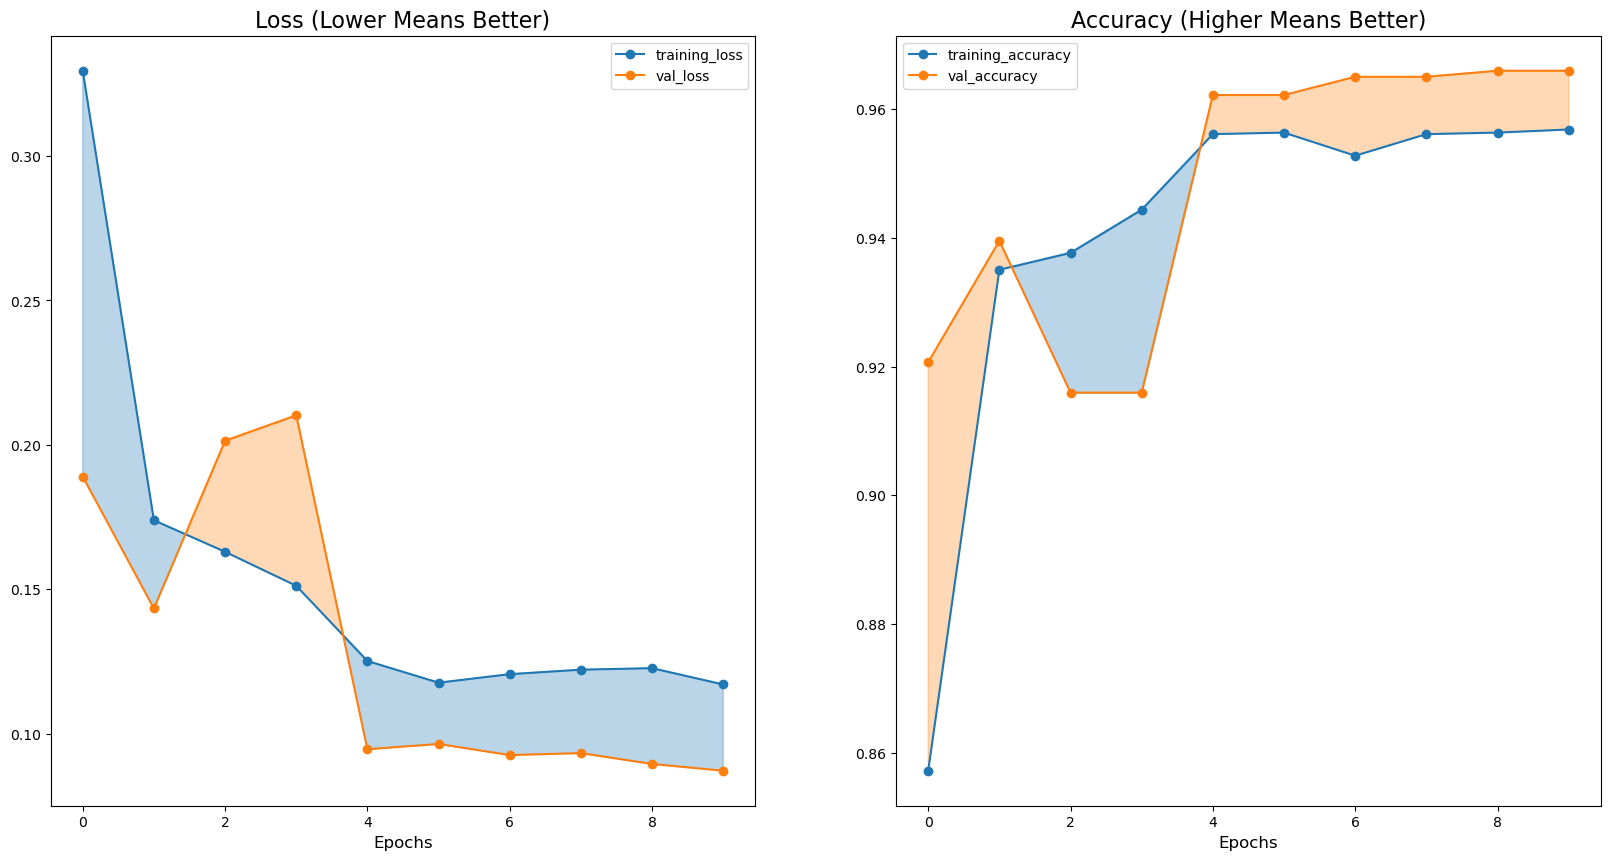

In [75]:
# plot cnn model learning cureve 
plot_training_curves(cnn_history)

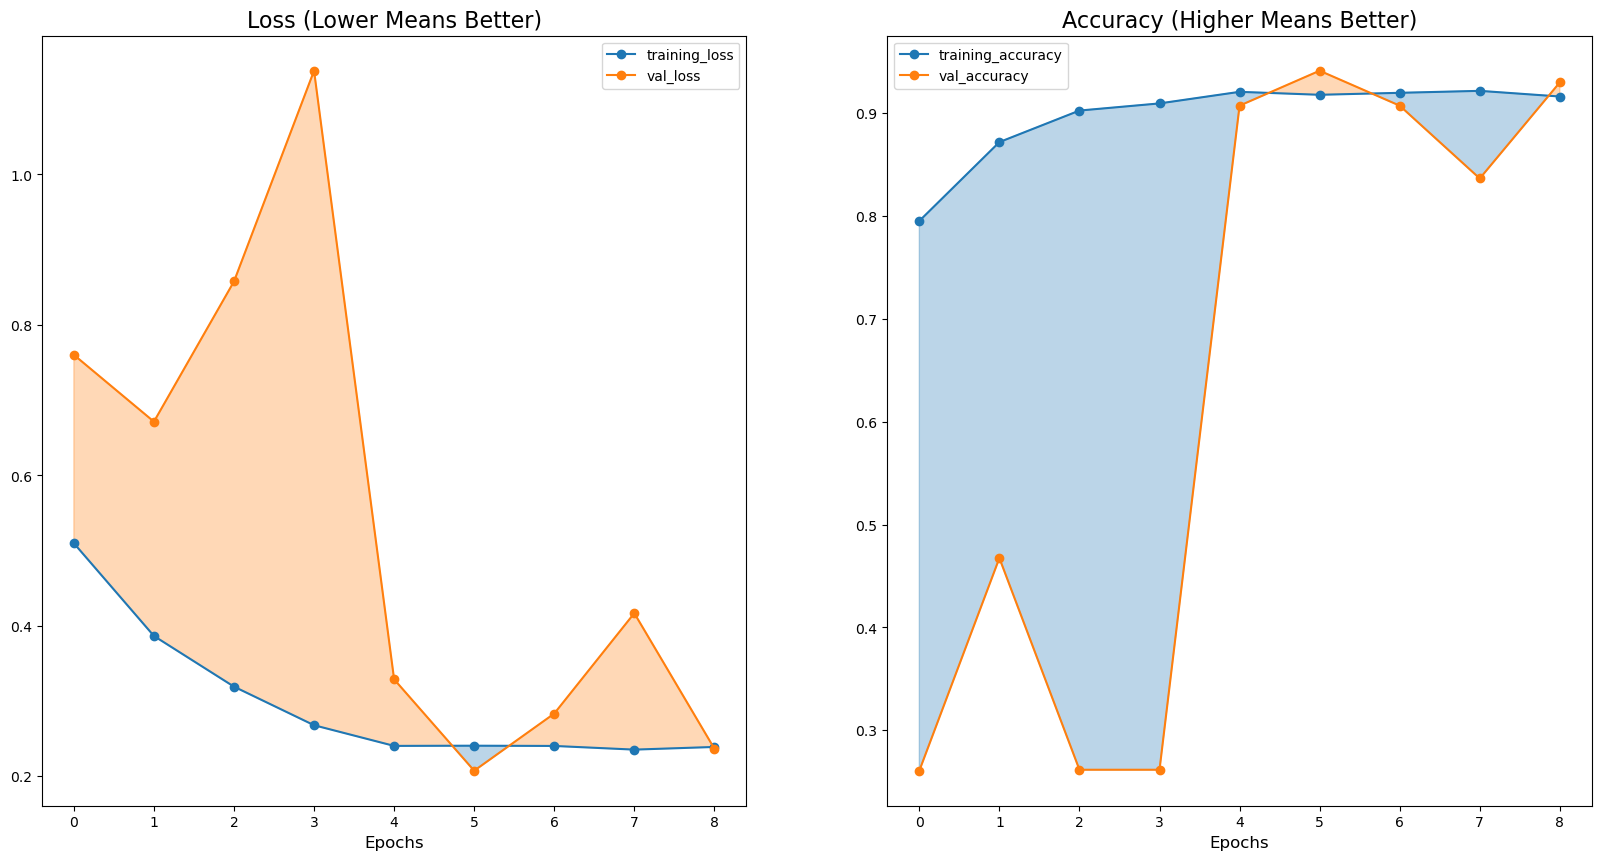

In [76]:
# Plot ResNet50 V2 model learning curve
plot_training_curves(resnet_history)

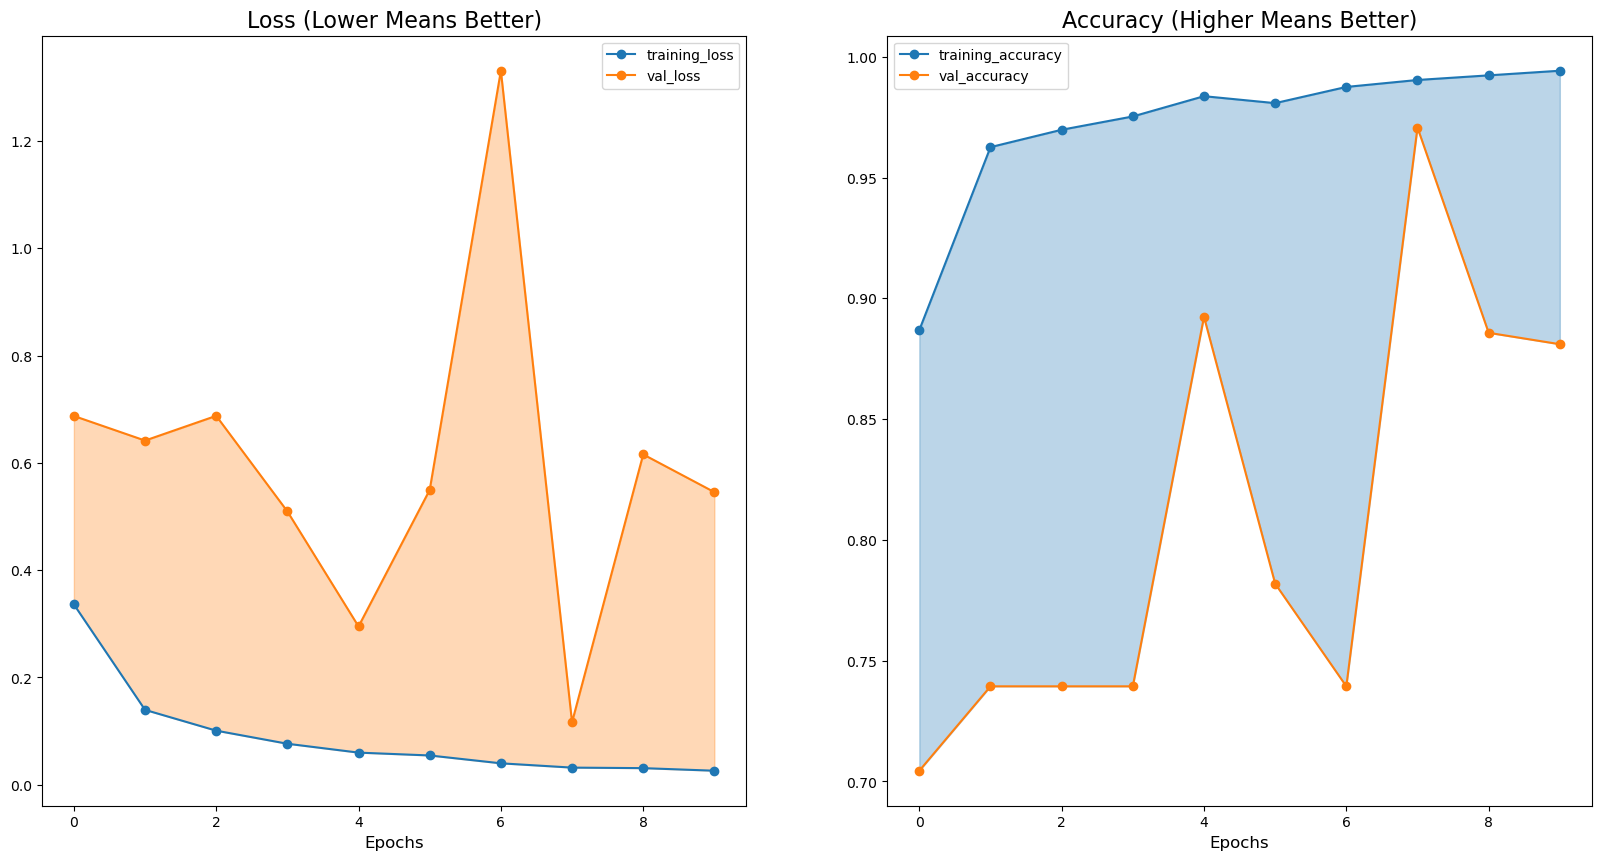

In [77]:
# Plot EfficientNet V1 B0 model learning curve
plot_training_curves(efficientnet_b0_history)

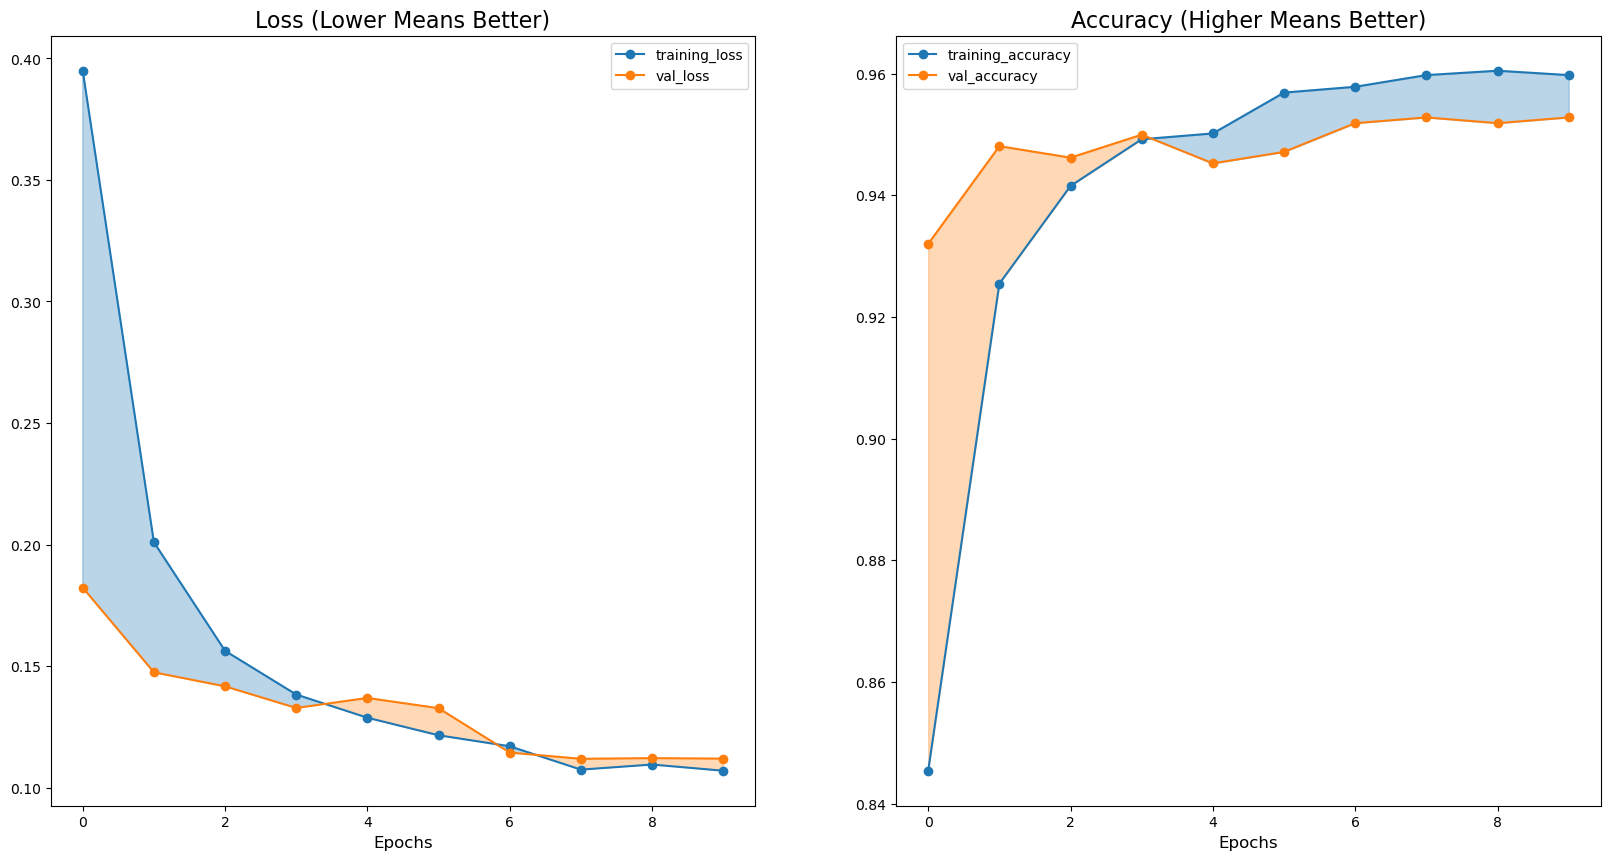

In [78]:
# Plot EfficientNet V2 B0 model learning curve 
plot_training_curves(efficientnet_v2_history)

## Observation
By expanding the size of our validation set, we noticed that the models were capable of converging to a reduced loss except for ResNet50 and EfficientB0.
We also observed that no overfitting had occured for CNNs and EfficientNetV2B0 during training and our models avoided underfitting on the training set as well.

## Plot Confusion Matrices
Confusion matrics will use to visually inspect correctly and misclassified predictions made by the model.

In [79]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    """
    Plots a confusion matrix using seaborn heatmap.

    Parameters:
    - y_true (list or array-like): True labels.
    - y_pred (list or array-like): Predicted labels.
    - classes (list or 'auto'): List of class names or 'auto' to auto-detect from y_true and y_pred.
        Default is 'auto'.
    - figsize (tuple): Size of the figure to be plotted. Default is (10, 10).
    - text_size (int): Font size of the annotations in the heatmap. Default is 12.

    Returns:
    - None. (Displays the confusion matrix heatmap)
    """

    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    # Uses seaborn for visual aesthetics
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',     # 'Greens' color map and annotations
        annot_kws={"size": text_size},     # setting annotation size
        fmt='g',                           # format for the annotations string
        linewidths=1, linecolor='black',   # setting boundary lines for cells
        xticklabels=classes, yticklabels=classes)  # setting class names as labels
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)  # keeps y-labels upright

    # Display the confusion matrix
    plt.show()

    # Since there's no return statement, function will return None by default
    return

## CNN Confusion Matrix

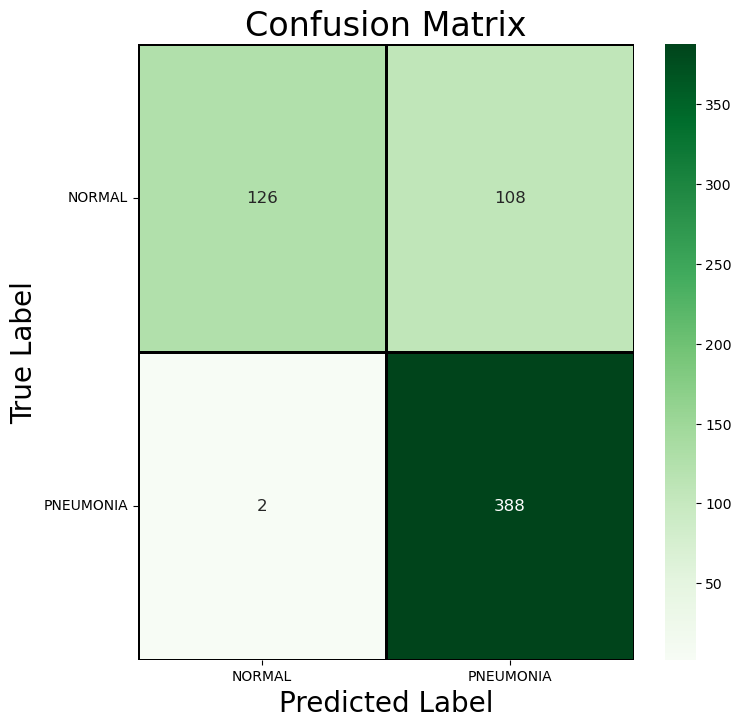

In [80]:
# Define the class labels
class_names = ['NORMAL', 'PNEUMONIA']

# Plot the confusion matrix for CNN's test predictions
plot_confusion_matrix(
    test_df.label_encoded,       # True labels
    cnn_test_predictions,        # CNN model's predictions
    figsize=(8, 8),              # Plot size
    classes=class_names)         # Class labels


## ResNet Confusion Matrix

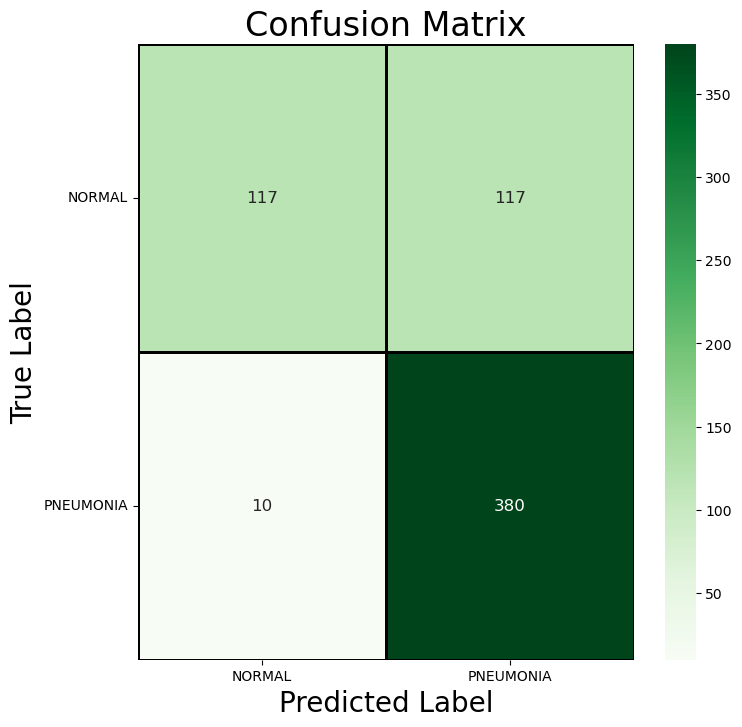

In [81]:
# Plotting the confusion matrix for the test predictions using ResNet.
plot_confusion_matrix(
    test_df.label_encoded,       # True labels
    resnet_test_predictions,     # ResNet model's predictions
    figsize=(8, 8),              # Plot size
    classes=class_names)         # Class labels


## EfficientNet V1 Confusion Matrix

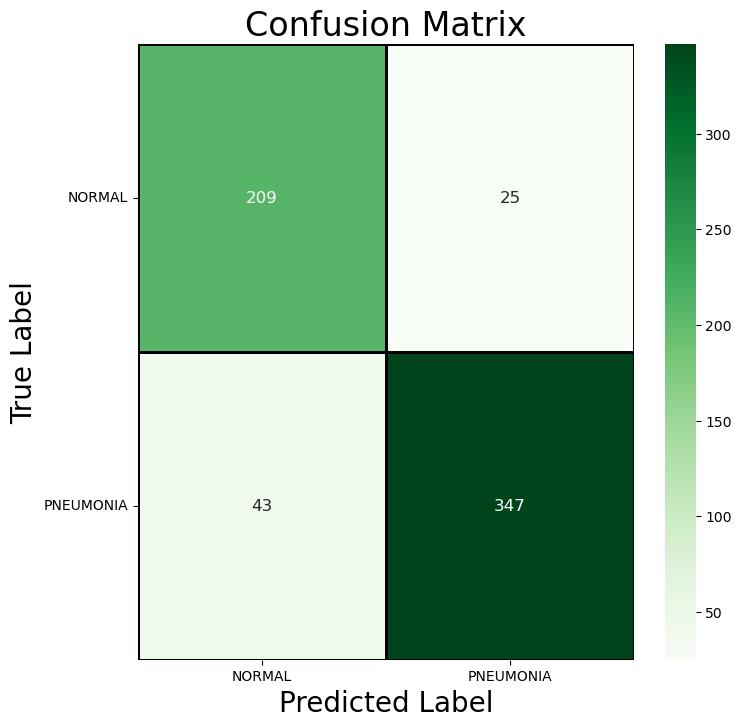

In [82]:
# Plot the confusion matrix for EfficientNet V1's test predictions
plot_confusion_matrix(
    test_df.label_encoded,            # True labels
    efficientnet_b0_test_predictions, # EfficientNet V1 model's predictions
    figsize=(8, 8),                   # Plot size
    classes=class_names)              # Class labels


## EfficientNet V2 Confusion Matrix

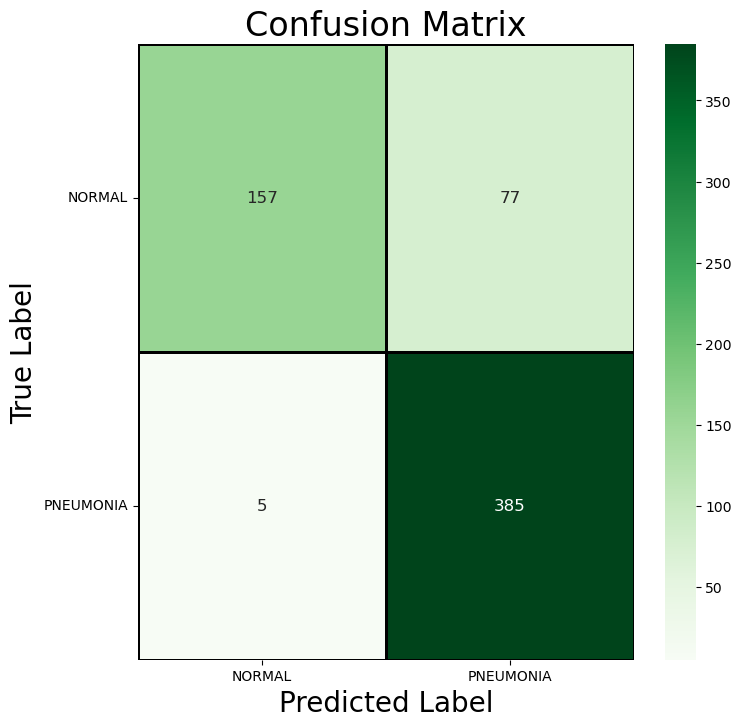

In [83]:
# Plot confusion matrix for EfficientNet V2's test predictions
plot_confusion_matrix(
    test_df.label_encoded,             # True labels
    efficientnet_v2_test_predictions,  # EfficientNet V2 model's predictions
    figsize=(8, 8),                    # Plot size
    classes=class_names)               # Class labels


## Observation
The advantages of transfer learning appear to be quite effective, as the basic CNN is surpassed in performance by the transfer learning models (EfficientNetB0 and EfficientNetV2B0). Notably, EfficientNet B0 outperforms all other models.

## Plot ROC Curves
An ROC (Receiver Operating Characteristic) curve is a visual representation that shows how well a binary classifier system can distinguish between two classes. This curve is constructed by plotting the true positive rate (TPR) on the vertical axis and the false positive rate (FPR) on the horizontal axis while adjusting the classification threshold at different points.

## CNN ROC Curves

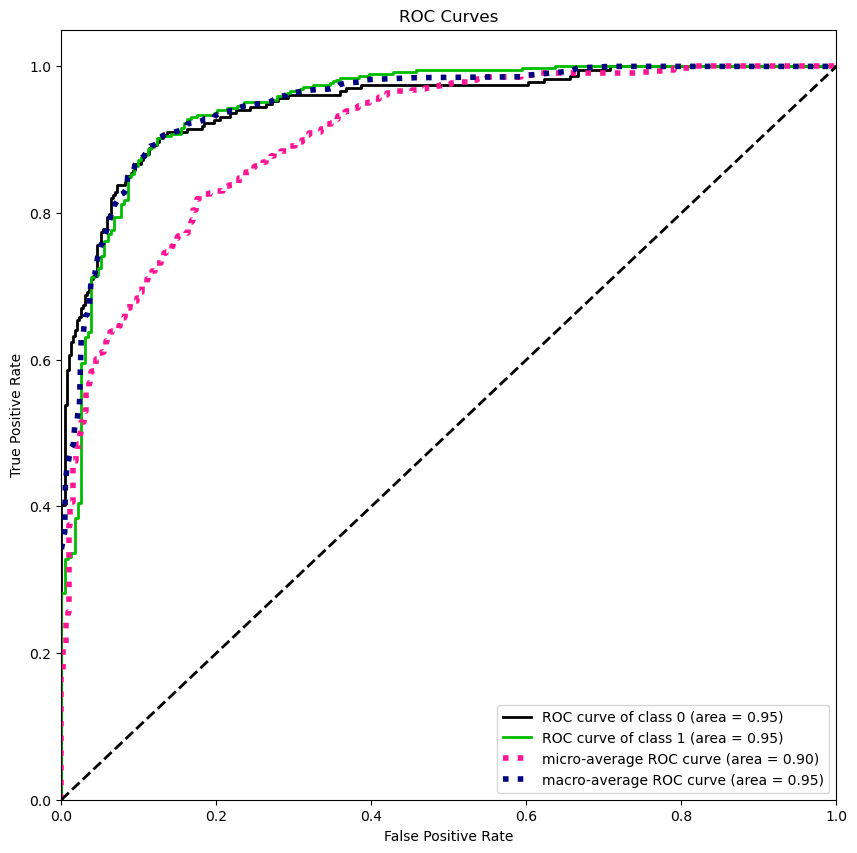

In [84]:
# Plot ROC curve for the CNN model's test probabilities
plot_roc(
    test_df.label_encoded,     # True labels
    cnn_test_probabilities,    # CNN model's predicted probabilities
    figsize=(10, 10),          # Plot size
    title_fontsize='large'     # Title font size
);


## ResNet ROC Curves

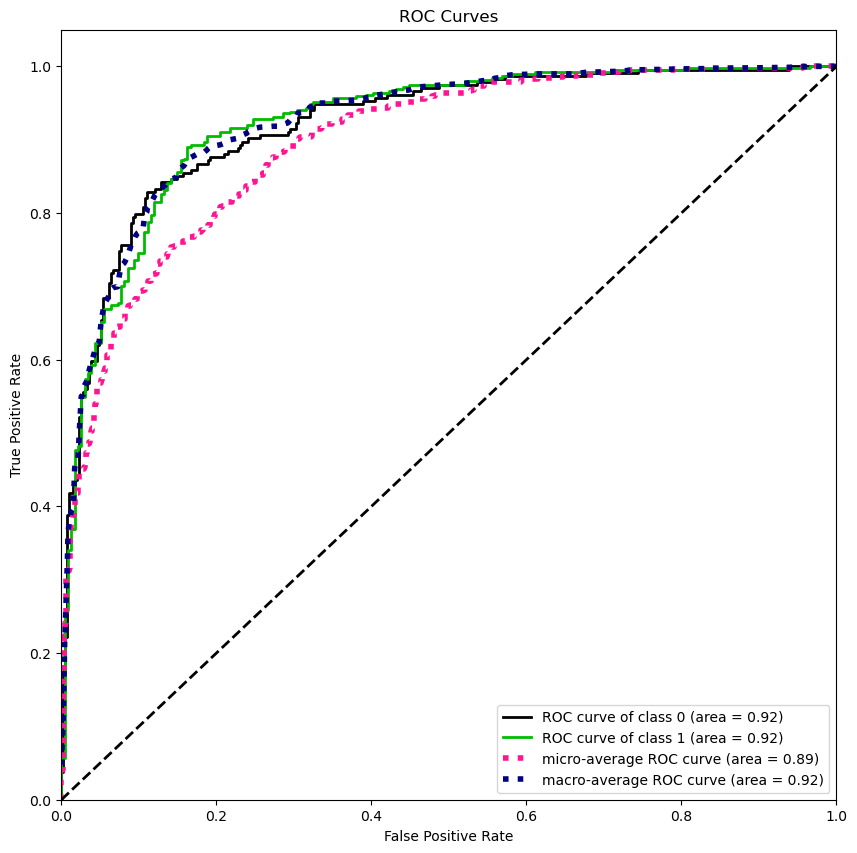

In [85]:
# Plot ROC curve for the ResNet model's test probabilities
plot_roc(
    test_df.label_encoded,         # True labels
    resnet_test_probabilities_fine,     # ResNet model's predicted probabilities
    figsize=(10, 10),              # Plot size
    title_fontsize='large'         # Title font size
);


## EfficientNet V1 ROC Curves

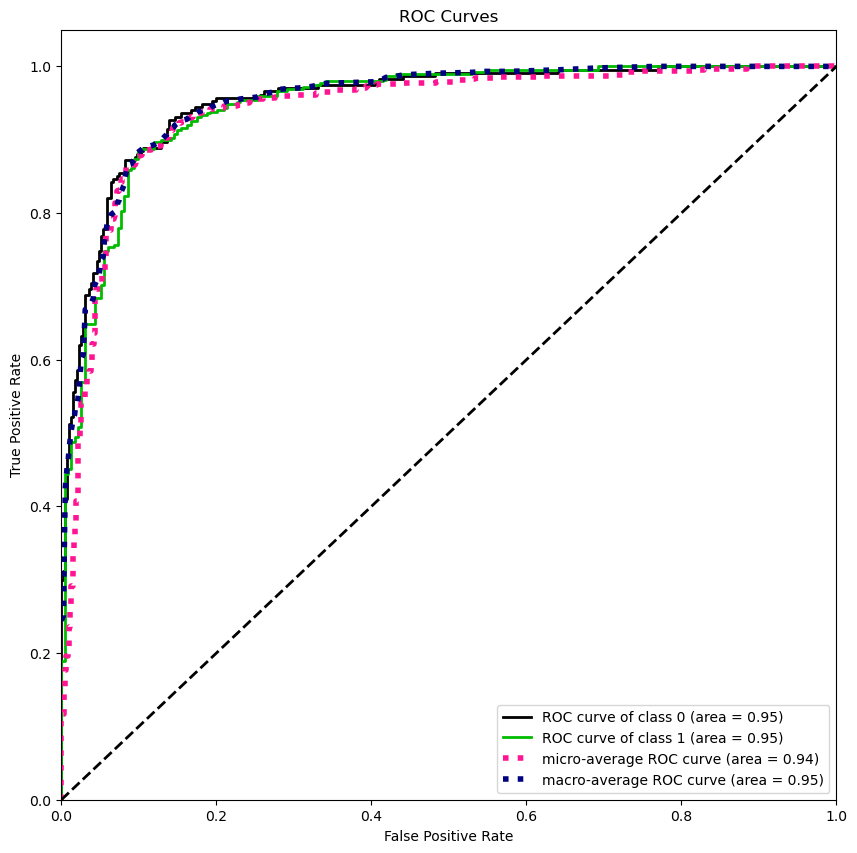

In [86]:
# Plot ROC curve for the EfficientNet V1 model's test probabilities
plot_roc(
    test_df.label_encoded,                  # True labels
    efficientnet_b0_test_probabilities,     # EfficientNet V1 model's predicted probabilities
    figsize=(10, 10),                       # Plot size
    title_fontsize='large'                  # Title font size
);


## EfficientNet V2 ROC Curves

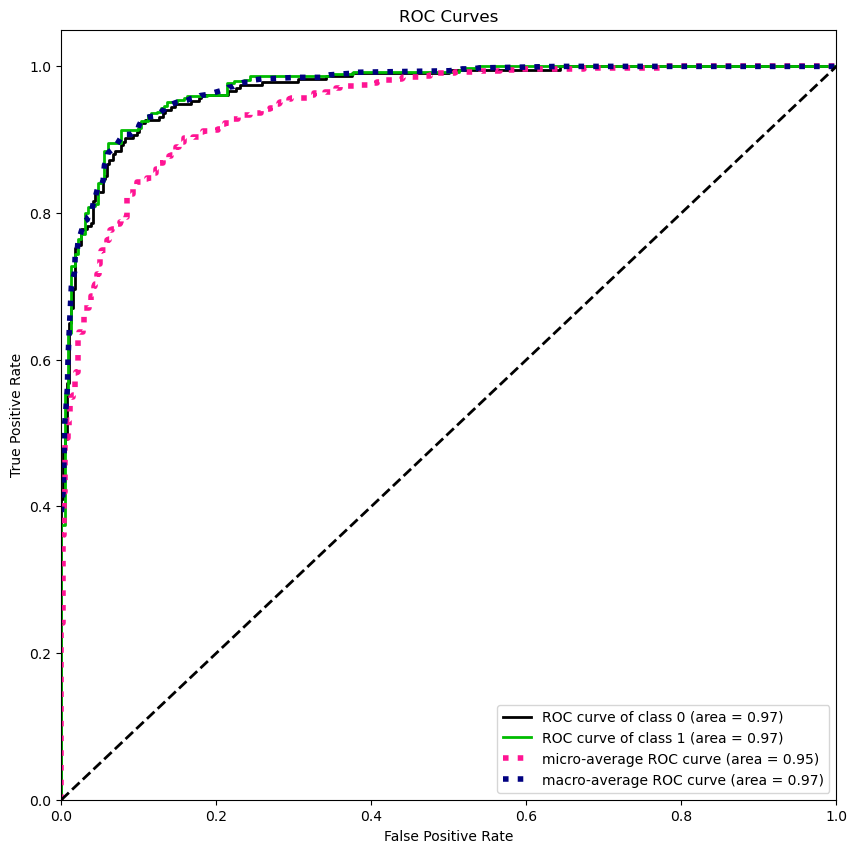

In [87]:
# Plot ROC curve for EfficientNet V2 model's test probabilities
plot_roc(
    test_df.label_encoded,                 # True labels
    efficientnet_v2_test_probabilities,    # EfficientNet V2 model's predicted probabilities
    figsize=(10, 10),                      # Plot size
    title_fontsize='large'                 # Title font size
);


## Observation
The transfer learning model EfficientNet V2 B0 have outperformed all other models by achieving slight better ROC Curves.

## Inpsect Classification Reports

In [88]:
# Print classification report for cnn
print(classification_report(test_df.label_encoded, cnn_test_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.98      0.54      0.70       234
   PNEUMONIA       0.78      0.99      0.88       390

    accuracy                           0.82       624
   macro avg       0.88      0.77      0.79       624
weighted avg       0.86      0.82      0.81       624



## Resnet Report

In [89]:
# Print classification report for Resnet
print(classification_report(test_df.label_encoded, resnet_test_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.92      0.50      0.65       234
   PNEUMONIA       0.76      0.97      0.86       390

    accuracy                           0.80       624
   macro avg       0.84      0.74      0.75       624
weighted avg       0.82      0.80      0.78       624



## EfficientNet V1 Report

In [90]:
# Print classification report for EfficientNet V1
print(classification_report(test_df.label_encoded, efficientnet_b0_test_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.83      0.89      0.86       234
   PNEUMONIA       0.93      0.89      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.89      0.89       624
weighted avg       0.89      0.89      0.89       624



## EfficientNet V2 Report

In [91]:
# Print classification report for EfficientNet V2
print(classification_report(test_df.label_encoded, efficientnet_v2_test_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.97      0.67      0.79       234
   PNEUMONIA       0.83      0.99      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



## Observation
The baseline CNN is outperformed by all other models in the classifcation report except ResNet50. EfficientNet b0 achieved the highest accuracy of 89%.

## Record Classification Metrics

In [92]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    """
    Calculates and prints performance metrics for the model and returns them in a dictionary.
    """
    
    # Calculate performance metrics
    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_matthews_corrcoef = round(matthews_corrcoef(y_true, y_pred), 5)
    
    # Display the calculated metrics
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')
    print('=============================================')
    
    # Return metrics in a dictionary format
    preformance_scores = {
        'accuracy_score': model_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores


In [93]:
# Generate and store performance metrics for the CNN model's predictions
cnn_performance = generate_preformance_scores(
    test_df.label_encoded,      # True labels
    cnn_test_predictions,       # CNN model's predictions
    cnn_test_probabilities      # CNN model's predicted probabilities
)



Performance Metrics:

accuracy_score:		0.82372

_____________________________________________
precision_score:	0.8580519153225805

_____________________________________________
recall_score:		0.8237179487179487

_____________________________________________
f1_score:		0.8084537869623236

_____________________________________________
matthews_corrcoef:	0.63943



In [94]:
# Generate and store performance metrics for the ResNet model's predictions
resnet_performance = generate_preformance_scores(
    test_df.label_encoded,        # True labels
    resnet_test_predictions,      # ResNet model's predictions
    resnet_test_probabilities_fine     # ResNet model's predicted probabilities
)



Performance Metrics:

accuracy_score:		0.79647

_____________________________________________
precision_score:	0.8233396441641978

_____________________________________________
recall_score:		0.7964743589743589

_____________________________________________
f1_score:		0.7785877572945

_____________________________________________
matthews_corrcoef:	0.57038



In [95]:
# Generate and store performance metrics for the EfficientNet V1 model's predictions
efficientnet_b0_performance = generate_preformance_scores(
    test_df.label_encoded,                  # True labels
    efficientnet_b0_test_predictions,       # EfficientNet V1 model's predictions
    efficientnet_b0_test_probabilities      # EfficientNet V1 model's predicted probabilities
)



Performance Metrics:

accuracy_score:		0.89103

_____________________________________________
precision_score:	0.8940092165898617

_____________________________________________
recall_score:		0.8910256410256411

_____________________________________________
f1_score:		0.8917565859823079

_____________________________________________
matthews_corrcoef:	0.77246



In [96]:
# Generate and store performance metrics for the EfficientNet V2 model's predictions
efficientnet_v2_performance = generate_preformance_scores(
    test_df.label_encoded,                  # True labels
    efficientnet_v2_test_predictions,       # EfficientNet V2 model's predictions
    efficientnet_v2_test_probabilities      # EfficientNet V2 model's predicted probabilities
)



Performance Metrics:

accuracy_score:		0.86859

_____________________________________________
precision_score:	0.8842592592592593

_____________________________________________
recall_score:		0.8685897435897436

_____________________________________________
f1_score:		0.8621959026888604

_____________________________________________
matthews_corrcoef:	0.72672



In [97]:
# Create a DataFrame to consolidate performance metrics from all models
performace_df = pd.DataFrame({
    'model_cnn': cnn_performance,
    'model_resnet': resnet_performance,
    'model_efficientnet_b0': efficientnet_b0_performance,
    'model_efficientnet_v2': efficientnet_v2_performance,
}).T

# Display the consolidated performance metrics
performace_df


,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
model_cnn,0.82372,0.858052,0.823718,0.808454,0.63943
model_resnet,0.79647,0.823340,0.796474,0.778588,0.57038
model_efficientnet_b0,0.89103,0.894009,0.891026,0.891757,0.77246
model_efficientnet_v2,0.86859,0.884259,0.868590,0.862196,0.72672


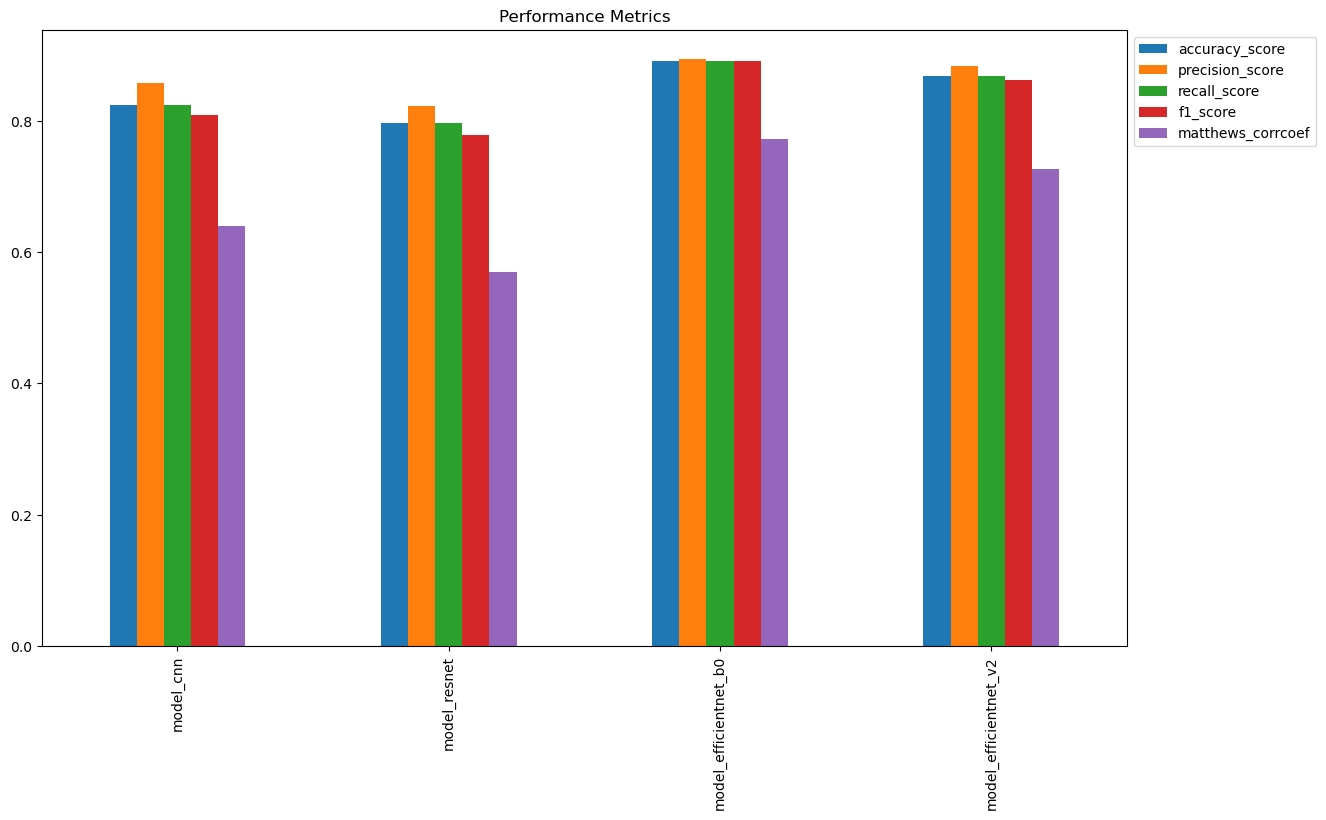

In [98]:
# Plot a bar chart of the performance metrics for each model
performace_df.plot(kind="bar", figsize=(14, 8), title='Performance Metrics').legend(bbox_to_anchor=(1.0, 1.0));


## Observation
The pre-trained transfer learning models EfficientNet outperform our baseline CNN model, especially with Matthews Correlation Coefficient(MCC).Higher MCC indicate that our model's predictions are statistically of high quality and able to generalise  unseen samples.

## Trade-offs: Inference Time vs. Performance
To choose the most suitable model for real-world applications, we must weigh the trade-offs associated with each model, considering both the time it takes to make predictions on a sample and its overall performance on generalizes to unseen data. This evaluation involves measuring the average prediction time for a given sample and analyzing this inference time in relation to a relevant performance metric. When assessing trade-offs, we will be using MCC as any model can potentially overfit, resulting in a high accuracy but poor performance on unseen data.


In [99]:
# Code reference from: "The Correct Way to Measure Inference Time of Deep Neural Networks", 2023. [Online]
# Avaliable: https://deci.ai/blog/measure-inference-time-deep-neural-networks/

def compute_inference_time(model, ds, sample_count):
    """
    Compute and print average inference time and rate for a given model using multiple trials.
    """
    
    # Lists to store inference times and rates across trials
    total_inference_times = []
    inference_rates = []
    
    # Compute inference times and rates for 5 trials
    for _ in range(5):
        start = time.perf_counter()
        model.predict(ds)
        end = time.perf_counter() 
        
        total_inference_times.append(end - start)
        inference_rates.append(total_inference_times[-1] / sample_count)
    
    # Compute average inference time and its uncertainty
    avg_inference_time = sum(total_inference_times) / len(total_inference_times)
    avg_inference_time_uncertainty = (max(total_inference_times) - min(total_inference_times)) / 2
    
    # Compute average inference rate and its uncertainty
    avg_inference_rate = sum(inference_rates) / len(inference_rates)
    avg_inference_rate_uncertainty = (max(inference_rates) - min(inference_rates)) / 2
    
    # Display the results
    print('====================================================')
    print(f'Model:\t\t{model.name}\n')
    print(f'Inference Time:\t{round(avg_inference_time, 6)}s \xB1 {round(avg_inference_time_uncertainty, 6)}s')
    print(f'Inference Rate:\t{round(avg_inference_rate, 6)}s/sample \xB1 {round(avg_inference_rate_uncertainty, 6)}s/sample')
    print('====================================================')
    
    return avg_inference_time, avg_inference_rate


In [100]:
# Calculate inference time for the CNN model
cnn_inference = compute_inference_time(model_cnn, test_ds, len(test_df))

20/20 [==============================] - 5s 255ms/step
Model:		cnn_sequential_model

Inference Time:	5.258234s ± 0.172026s
Inference Rate:	0.008427s/sample ± 0.000276s/sample


In [101]:
# Calculate inference time for the ResNet model
resnet_inference = compute_inference_time(model_resnet, test_ds, len(test_df))

20/20 [==============================] - 43s 2s/step
Model:		resnet_model

Inference Time:	40.874911s ± 1.917102s
Inference Rate:	0.065505s/sample ± 0.003072s/sample


In [102]:
# Calculate inference time for the EfficientNet V1 model
efficientnet_b0_inference = compute_inference_time(model_efficientnet_b0, test_ds, len(test_df))

20/20 [==============================] - 21s 1s/step
Model:		efficientnet_b0_model

Inference Time:	20.982487s ± 0.731206s
Inference Rate:	0.033626s/sample ± 0.001172s/sample


In [103]:
# Calculate inference time for the Efficient V2 model
efficientnet_v2_inference = compute_inference_time(model_efficientnet_v2, test_ds, len(test_df))

20/20 [==============================] - 16s 790ms/step
Model:		efficientnet_v2_sequential_model

Inference Time:	15.907517s ± 0.266763s
Inference Rate:	0.025493s/sample ± 0.000428s/sample


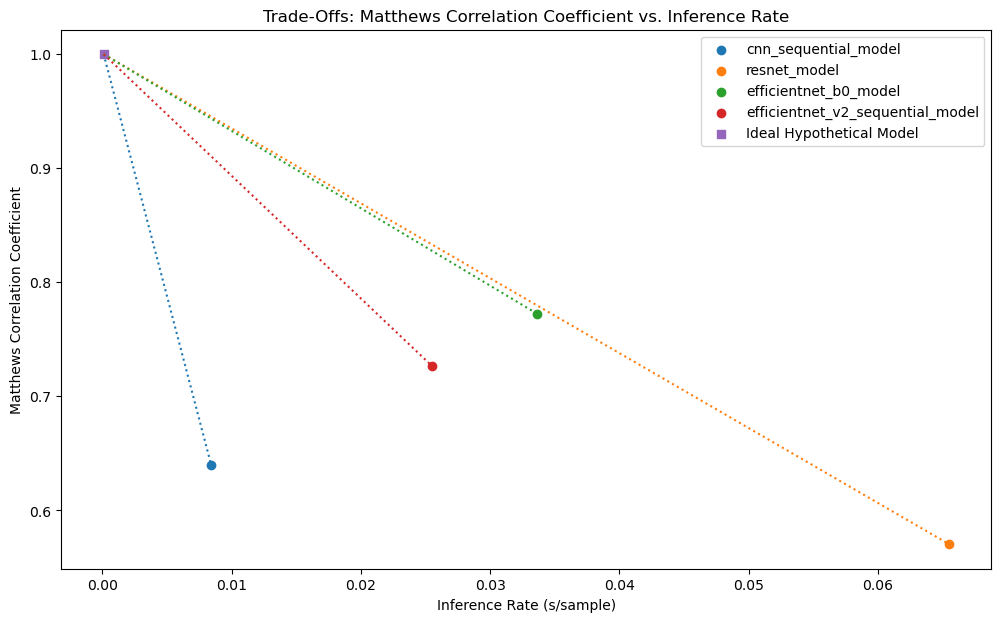

In [104]:
# Extracting MCC (Matthews Correlation Coefficient) values for each model
cnn_mcc = cnn_performance["matthews_corrcoef"]
resnet_mcc = resnet_performance["matthews_corrcoef"]
efficientnet_b0_mcc = efficientnet_b0_performance["matthews_corrcoef"]
efficientnet_v2_mcc = efficientnet_v2_performance["matthews_corrcoef"]

# Initialize a scatter plot to compare inference rate with MCC for each model
plt.figure(figsize=(12, 7))

# Plotting each model's MCC against its inference rate
plt.scatter(cnn_inference[1], cnn_mcc, label=model_cnn.name)
plt.scatter(resnet_inference[1], resnet_mcc, label=model_resnet.name)
plt.scatter(efficientnet_b0_inference[1], efficientnet_b0_mcc, label=model_efficientnet_b0.name)
plt.scatter(efficientnet_v2_inference[1], efficientnet_v2_mcc, label=model_efficientnet_v2.name)

# Defining ideal model metrics for reference
ideal_inference_rate = 0.0001 # Exemplary ideal inference time
ideal_mcc = 1.0 # Perfect MCC score

# Plotting an ideal model point and connecting each real model to this point
plt.scatter(ideal_inference_rate, ideal_mcc, label="Ideal Hypothetical Model", marker='s')
plt.plot([ideal_inference_rate, cnn_inference[1]], [ideal_mcc, cnn_mcc], ':')
plt.plot([ideal_inference_rate, resnet_inference[1]], [ideal_mcc, resnet_mcc], ':')
plt.plot([ideal_inference_rate, efficientnet_b0_inference[1]], [ideal_mcc, efficientnet_b0_mcc], ':')
plt.plot([ideal_inference_rate, efficientnet_v2_inference[1]], [ideal_mcc, efficientnet_v2_mcc], ':')

# Setting plot labels, title, and legend
plt.legend()
plt.title("Trade-Offs: Matthews Correlation Coefficient vs. Inference Rate")
plt.xlabel("Inference Rate (s/sample)")
plt.ylabel("Matthews Correlation Coefficient");


In [105]:
# Function to compute Euclidean distance between two points
def dist(x1, x2, y1, y2):
    return np.sqrt(np.square(x2 - x1) + np.square(y2 - y1))

# Lists of model names, their scores (MCC) and inference rates
model_names = [model_cnn.name, model_resnet.name, model_efficientnet_b0.name, model_efficientnet_v2.name]
model_scores = [cnn_mcc, resnet_mcc, efficientnet_b0_mcc, efficientnet_v2_mcc]
model_rates = [cnn_inference[1], resnet_inference[1], efficientnet_b0_inference[1], efficientnet_v2_inference[1]]

# Calculate trade-off scores for each model compared to an ideal model
trade_offs = [dist(ideal_inference_rate, inference_rate, ideal_mcc, score) for inference_rate, score in zip(model_rates, model_scores)]

# Print trade-off scores for each model
print('Trade-Off Score: Inference Rate vs. MCC')
for name, inference_rate, score, trade in zip(model_names, model_rates, model_scores, trade_offs):
    print('---------------------------------------------------------')
    print(f'Model: {name}\n\nInference Rate: {inference_rate:.5f} | MCC: {score:.4f} | Trade-Off: {trade:.4f}')

# Identify and print the model with the best trade-off score
print('=========================================================')
best_model_trade = min(trade_offs)
best_model_name = model_names[np.argmin(trade_offs)]
print(f'\nBest Model:\t{best_model_name}\nBest Trade-Off: {best_model_trade:.4f}\n')
print('=========================================================')


Trade-Off Score: Inference Rate vs. MCC
---------------------------------------------------------
Model: cnn_sequential_model

Inference Rate: 0.00843 | MCC: 0.6394 | Trade-Off: 0.3607
---------------------------------------------------------
Model: resnet_model

Inference Rate: 0.06550 | MCC: 0.5704 | Trade-Off: 0.4346
---------------------------------------------------------
Model: efficientnet_b0_model

Inference Rate: 0.03363 | MCC: 0.7725 | Trade-Off: 0.2300
---------------------------------------------------------
Model: efficientnet_v2_sequential_model

Inference Rate: 0.02549 | MCC: 0.7267 | Trade-Off: 0.2745

Best Model:	efficientnet_b0_model
Best Trade-Off: 0.2300



## Conclusion

In this project, we explored the classification of Pneumonia using Convolutional Neural Networks (CNNs) and leveraged Transfer Learning techniques. We employed pre-trained models, including ResNet50 V2, EfficientNet B0, and EfficientNet V2 B0, to build models that outperformed the baseline CNN model on Trade-offs score. When considering the trade-offs between inference speed and model performance, EfficientNet B0 emerged as the optimal choice, surpassing all other models in terms of balancing these factors, particularly excelling in Matthews Correlation Coefficient (MCC).

It's crucial to emphasize that in the context of Pneumonia detection, a dedicated model should exhibit exceptionally high accuracy and MCC values, ideally approaching 100% and 1.0, respectively. Misclassifications in Pneumonia cases could have severe consequences, highlighting the necessity for a state-of-the-art (SOTA) performance model. Such a model could greatly influence the decisions made by healthcare professionals dealing with Pneumonia cases, making excellence a paramount requirement for real-world applications.


## Suggest Further Work

### Extended Datasets:
- Integrate diverse datasets for enhanced model generalization.
- Include images from varied demographics, different medical equipment, and multiple resolutions.
- Aim to reduce biases and improve model applicability across clinical settings.
### Advanced Models and Ensembling:
- Explore advanced models like EfficientNetB7 or Vision Transformers (ViTs).
- Consider ensemble methodologies to combine insights from multiple models.
- Prioritize accuracy over speed, especially given the clinical significance of pneumonia detection.
- Explore alternative fine-tuning techniques for performance optimization.
- Address class imbalance using techniques like oversampling, undersampling, or SMOTE.
### Model Interpretability and Real-time Detection:
- Integrate tools like SHAP or LIME for better model interpretability.
- Transition towards real-time detection for immediate diagnostics in clinical settings.
### Multimodal Learning and Anomaly Detection:
- Combine X-ray imagery with patient metadata or clinical records.
- Utilize anomaly detection techniques to identify unusual patterns indicative of other medical conditions.
### Federated and Few-shot Learning:
- Implement federated learning for training across multiple healthcare institutions without sharing raw data.
- Use few-shot or one-shot learning techniques in scenarios with limited labeled data.
### Robustness Testing and Feedback Loop:
- Test model resilience against adversarial attacks and corrupted data.
- Establish a feedback loop for clinicians to validate and provide insights on model predictions.
### User-Centric Design and Deployment:
- Emphasize user studies and feedback collection to align the system with medical practitioners' workflows.
- Focus on refining user experience and addressing specific clinical needs.
- Explore optimization techniques for quicker model inference, vital for real-time clinical diagnosis.
- Prioritize deployment and integration of the model in clinical settings.
- Develop a user-friendly interface or integrate with existing healthcare systems.
- Ensure compliance with regulations, emphasizing patient privacy and data security.

These recommendations, when pursued, have the potential to substantially augment the project's efficacy and relevance in clinical diagnostics.